# This notebook allows the recreation of figures in the paper based on the resources provided in the linked github (https://github.com/fowler-lab/tb-rnap-compensation.git)

Load all necessary packages

In [1]:
import pandas
import numpy

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.stats import mannwhitneyu
from scipy.stats import bootstrap
import pylab
import scipy

from tqdm.autonotebook import tqdm
import warnings
warnings.filterwarnings('ignore')

/var/folders/nq/gpbdk7y11kvd1d9nk9s77b4c0000gn/T/ipykernel_32328/323221400.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Define color function and plotting parameters

In [2]:
flierprops = dict(markerfacecolor='0.75', markersize=5,
              linestyle='none')
box_args = dict(notch = True, fliersize = 5, flierprops = flierprops, whis = [2.5, 97.5], showfliers = False, orient = 'h')
hist_args = dict(bins = 30, alpha = 0.5, stat = "percent", edgecolor='k', linewidth = 0.2)

#defines color palette based on keywords
def palette(color = "colorblind"):
    
    if color == "dark":
        colors = sns.color_palette("dark")
        my_cmap = ListedColormap(sns.color_palette(colors).as_hex())
        return colors
    
    if color == "bright":
        colors = sns.color_palette("bright")
        my_cmap = ListedColormap(sns.color_palette(colors).as_hex())
        return colors
    
    if color == "muted":
        colors = sns.color_palette("muted")
        my_cmap = ListedColormap(sns.color_palette(colors).as_hex())
        return colors
    
    if color == "colorblind":
        colors = sns.color_palette("colorblind")
        my_cmap = ListedColormap(sns.color_palette(colors).as_hex())
        return colors

#takes a list of values as argument and gives the bootstrap median and CI
def my_bootstrap(data):
    
    median = round(data.median(), 2)
    CI = (round(bootstrap((data,), numpy.median, confidence_level = 0.95).confidence_interval.low, 2), 
          round(bootstrap((data,), numpy.median, confidence_level = 0.95).confidence_interval.high, 2))
    
    return median, CI

**Load all relevant data sets**

In [3]:
MUTATIONS = pandas.read_pickle('tb_rnap_compensation/tables/MUTATIONS.pkl.gz')
MUTATIONS.reset_index(inplace = True)
MUTATIONS = MUTATIONS.astype({'GENE':'str'})
MUTATIONS['GENE_MUTATION'] = MUTATIONS['GENE'] + '_' + MUTATIONS['MUTATION']
print('Done')

Done


In [4]:
GENOMES = pandas.read_pickle('tb_rnap_compensation/tables/GENOMES.pkl.gz')
print('Done')

Done


In [5]:
EFFECTS = pandas.read_pickle('tb_rnap_compensation/tables/EFFECTS.pkl.gz')
EFFECTS.reset_index(inplace = True)
EFFECTS['GENE_MUTATION'] = EFFECTS['GENE'] + '_' + EFFECTS['MUTATION']
EFFECTS = EFFECTS[(EFFECTS.DRUG=='RIF') & (EFFECTS.PREDICTION=='R') 
                  & (~EFFECTS.MUTATION.str[-1].isin(['O','X']))]
print('Done')

Done


In [6]:
PLATES = pandas.read_pickle('tb_rnap_compensation/tables/UKMYC_PLATES.pkl.gz')
PLATES.reset_index(inplace = True)
print('Done')

Done


In [7]:
print('There are', len(GENOMES.index.value_counts()), 'sequenced samples')

There are 77860 sequenced samples


**Figure 1: The drug rifampicin (RIF) interrupts RNA synthesis by binding to the $\beta$ subunit of the RNA polymerase (RNAP)**

Figure of RNAP with bound RIF was obtained in the software PyMOL, outside of this notebook. The crystal structure for the PyMOL file was obtained by Lin et al (pdb: 5UHB).

**Figure 2: Presence of rifampicin (RIF) resistance-conferring mutations in the RNA polymerase (RNAP) of M. tuberculosis is associated with lower median growth compared to pan-susceptible samples**

**Figure 2(A):** 

Distribution of growth in percent of covered well area as measured in a previous project was plotted in two different ways: On the bottom as a histogram against the proportion of samples that display this amount of growth. On top as a bar plot reflecting the distribution quantiles. Samples with RIF resistance mutations but no other potentially interfering mutations are plotted in red, samples that were classified as pan-susceptible are plotted in green. This plot reflects the entire dataset and the respective medians and the Mann-Whitney p-value are displayed in Table 1.

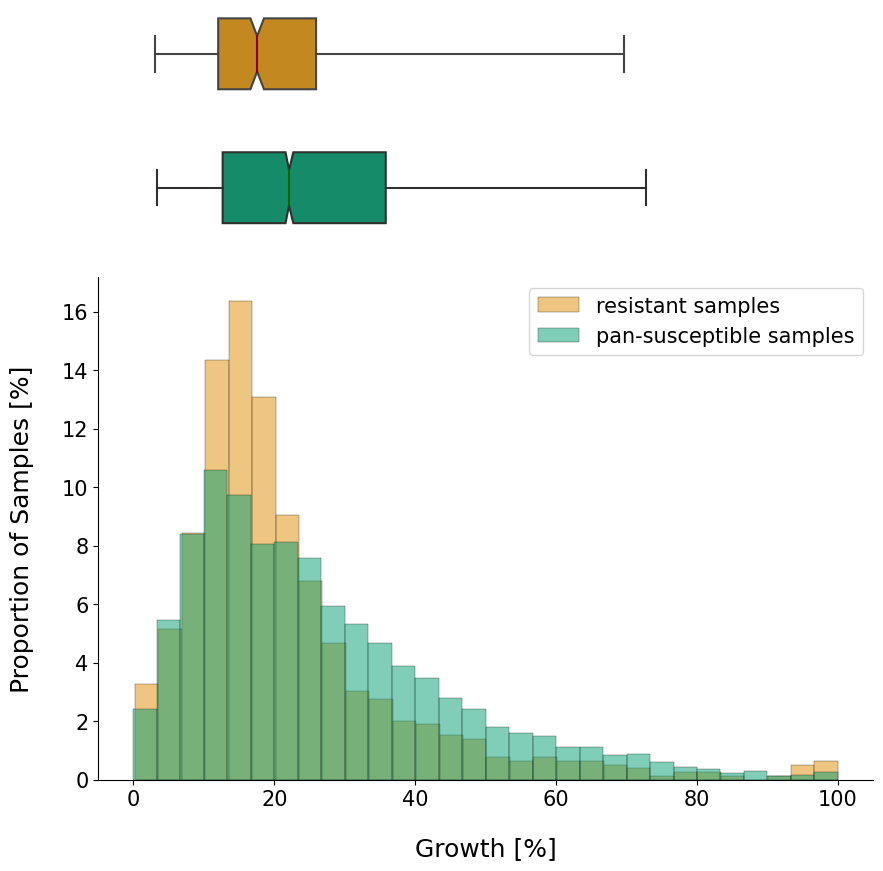

In [8]:
#set color palette
colors = palette("colorblind")

#load UNIQUEIDs of susceptible samples
pan_sus_samples = GENOMES[(GENOMES.WGS_PREDICTION_STRING.str[0:4].isin(['SSSS']))].index.to_series()

#make query for samples with resistance and only synonymous other mutations
res_gene_mutations = EFFECTS.GENE_MUTATION
query = res_gene_mutations.unique()

MUTATIONS['SYNONYMOUS'] = MUTATIONS['MUTATION'].apply(lambda x: x[0]==x[-1])
syn_mutations = MUTATIONS[MUTATIONS.SYNONYMOUS].GENE_MUTATION.unique()
query = numpy.append(query, syn_mutations)

MUTATIONS['QUERY'] = MUTATIONS.GENE_MUTATION.isin(query)
tmp = MUTATIONS[['UNIQUEID','QUERY']].groupby('UNIQUEID').mean()
only_query = tmp[tmp.QUERY == 1].index.to_series()

#load UNIQUEIDs of resistant samples
only_res = MUTATIONS[(MUTATIONS.GENE_MUTATION.isin(res_gene_mutations.unique())) 
                     & (MUTATIONS.UNIQUEID.isin(only_query))].UNIQUEID

#load growth data for suscpetible UNIQUEIDs
susceptible = PLATES[(PLATES.UNIQUEID.isin(pan_sus_samples.values.tolist()))].IM_POS_AVERAGE
susceptible.dropna(inplace = True)

#load growth data for resistant UNIQUEIDs
resistant = PLATES[(PLATES.UNIQUEID.isin(only_res.values.tolist()))].IM_POS_AVERAGE
resistant.dropna(inplace = True)

#calculate p-value
stat, p = mannwhitneyu(resistant, susceptible)
    
#calculate and save quantiles, median and confidence intervals from bootstrap approach
stats = []
sus_boot = my_bootstrap(susceptible)
stats.append(['pan-susceptible', sus_boot[0], sus_boot[1][0], sus_boot[1][1], 
              '', round(numpy.mean(susceptible), 2), len(susceptible)])      
res_boot = my_bootstrap(resistant)
stats.append(['any resistance', res_boot[0], res_boot[1][0], res_boot[1][1],
              str(p), round(numpy.mean(resistant), 2), len(resistant)])         

#Plot histograms with boxplots
fig, (ax_box1, ax_box2, ax_hist) = plt.subplots(3, sharex = True, 
                                                gridspec_kw = {"height_ratios": (0.15, 0.15, 0.85)})
#fig, ax = plt.subplots()
fig.set_size_inches(10, 10)


sns.histplot(data = resistant, label="resistant samples", color = colors[1], **hist_args)
#plt.axvline(resistant.median(), color = 'darkred', linewidth = 1)

sns.histplot(data = susceptible, label="pan-susceptible samples", color = colors[2], **hist_args)
#plt.axvline(susceptible.median(), color = 'darkgreen', linewidth = 1)

sns.boxplot(resistant.to_list(), ax = ax_box1, color = colors[1], medianprops={"color": "darkred"}, 
             usermedians = [res_boot[0]], conf_intervals = [res_boot[1]], **box_args)
sns.boxplot(susceptible.to_list(), ax = ax_box2, color = colors[2], medianprops={"color": "darkgreen"}, 
            usermedians = [sus_boot[0]], conf_intervals = [sus_boot[1]], **box_args)

#Despine plots
sns.despine(top = True, right=True, left = False, bottom = False, offset = False, trim = False)

axes = [ax_box1, ax_box2]
for ax in axes:
    sns.despine(ax = ax, top = True, right=True, left = True, bottom = True, offset = False, trim = False)
    ax.tick_params(left=False, bottom=False) 
    ax.set(yticklabels=[])
    ax.set(xlabel='')

#label plots
plt.xlabel("Growth [%]", size = 18, labelpad = 20)
plt.xticks(fontsize = 15)
plt.ylabel("Proportion of Samples [%]", size = 18, labelpad = 20)
plt.yticks(fontsize = 15)
plt.legend(loc = 'upper right', fontsize = 15)

#uncomment this for saving figure:
#fig.savefig('res_vs_sus.svg', format='svg', dpi=1200)

**Figure 2(B):** 

Plot structure equivalent to the box plot in A, but the red bars represent subsets of RIF resistant samples that exhibit only the resistance mutation indicated to their left and no other potentially interfering mutations. The medians, their confidence intervals (CI) and Mann-Whitney p-values of the distributions are listed in Table 1. For a histogram representation of the same data please refer to Supplementary Figure S1.

  0%|          | 0/113 [00:00<?, ?it/s]

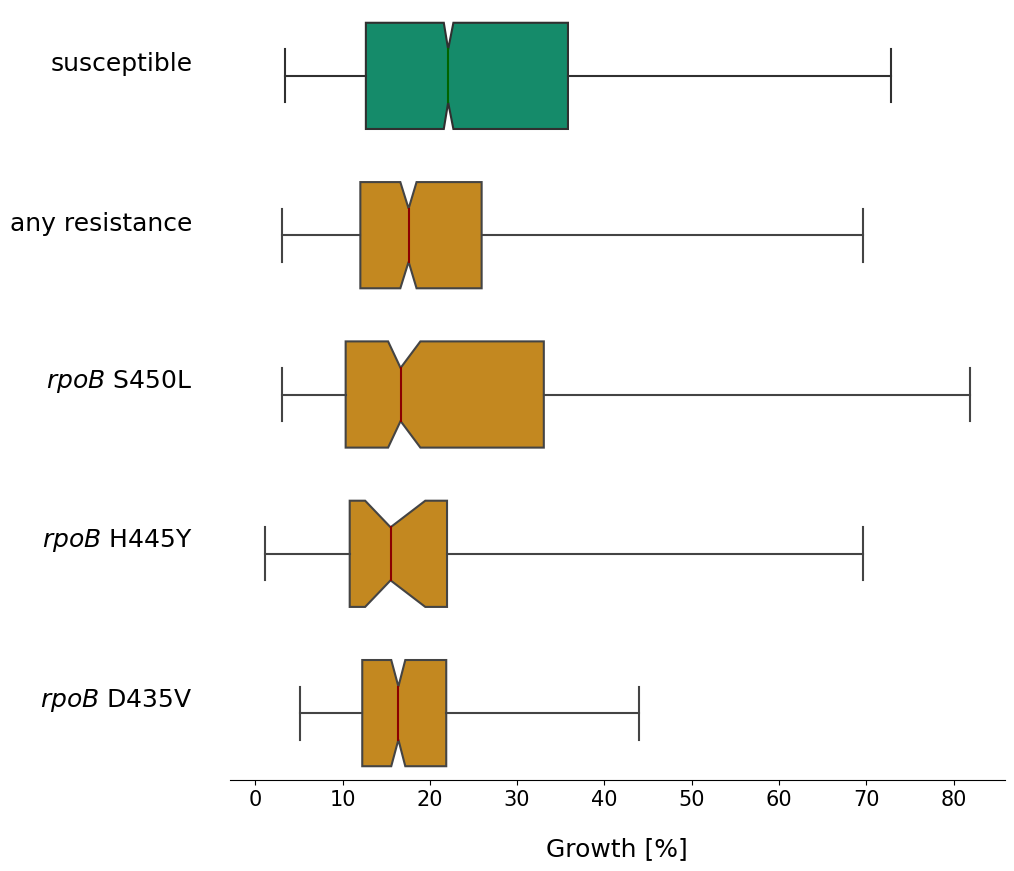

In [9]:
#load growth data for resistant UNIQUEIDs
resistant = PLATES[(PLATES.UNIQUEID.isin(only_res.values.tolist()))].IM_POS_AVERAGE
resistant.dropna(inplace = True)

#load growth data for suscpetible UNIQUEIDs
susceptible = PLATES[(PLATES.UNIQUEID.isin(pan_sus_samples.values.tolist()))].IM_POS_AVERAGE
susceptible.dropna(inplace = True)

#fetch resistance mutations
res_gene_mutations = EFFECTS.GENE_MUTATION.unique()

fig, (ax_box1, ax_box2, ax_box3, ax_box4, ax_box5) = plt.subplots(5, sharex = True, 
                                                gridspec_kw = {"height_ratios": (0.15, 0.15, 0.15, 0.15, 0.15)})

#plot figure
fig.set_size_inches(10, 10)

sus_boot = my_bootstrap(susceptible)
sns.boxplot(susceptible.to_list(), ax = ax_box1, color = colors[2], medianprops={"color": "darkgreen"},
            usermedians = [sus_boot[0]], conf_intervals = [sus_boot[1]], **box_args)
ax_box1.set_ylabel ('susceptible', fontsize = 18, labelpad = 20, rotation=0, horizontalalignment='right')

res_boot = my_bootstrap(resistant)
sns.boxplot(resistant.to_list(), ax = ax_box2, color = colors[1], medianprops={"color": "darkred"}, 
            usermedians = [res_boot[0]], conf_intervals = [res_boot[1]], **box_args)
ax_box2.set_ylabel ('any resistance', fontsize = 18, labelpad = 20, rotation=0, horizontalalignment='right')

axes = [ax_box3, ax_box4, ax_box5]
i=0

for res in tqdm(res_gene_mutations):
    
    #query for samples with resistance and only synonymous other mutations
    spec_res = MUTATIONS[(MUTATIONS.GENE_MUTATION == res) & (MUTATIONS.UNIQUEID.isin(only_query))].UNIQUEID
    
    #load growth data for resistant UNIQUEIDs
    resistant = PLATES[(PLATES.UNIQUEID.isin(spec_res.values.tolist()))].IM_POS_AVERAGE
    resistant.dropna(inplace = True)
    
    #set reasonable prevalence cut-off for resistance mutation
    if len(resistant) < 40:
        continue
    
    #calculate p-value
    stat, p = mannwhitneyu(resistant, susceptible)
    
    #plot growth distributions below p-value cut-off
    if p < (0.05):
        
        ax = axes[i]
        i = i+1

        res_boot = my_bootstrap(resistant)
        sns.boxplot(resistant.to_list(), ax = ax, color = colors[1], medianprops={"color": "darkred"}, 
                    usermedians = [res_boot[0]], conf_intervals = [res_boot[1]], **box_args)
       
        ax.set_ylabel ('$\it{rpoB}$' + ' ' + res[5:], fontsize = 18, labelpad = 20, 
                       rotation=0, horizontalalignment='right')
        
        #save p-value and median + CIs
        stats.append([res[0:4] + ' ' + res[5:], res_boot[0], res_boot[1][0], res_boot[1][1], 
                      str(p), round(numpy.mean(resistant), 2), len(resistant)])
        
#Despine plots

axes = [ax_box1, ax_box2, ax_box3, ax_box4, ax_box5]

for ax in axes:
    sns.despine(ax = ax, top = True, right=True, left = True, bottom = True, offset = False, trim = False)
    ax.tick_params(left=False, bottom=False) 
    ax.set(yticklabels=[])
    ax.set(xlabel='')

#Respine bottom plot

sns.despine(ax = ax_box5, top = True, right=True, left = True, bottom = False, offset = False, trim = False)
ax_box5.tick_params(left = False, bottom = True) 

plt.xlabel("Growth [%]", size = 18, labelpad = 20)
plt.xticks(fontsize = 15)

# uncomment this for creating figure:
fig.savefig('res_vs_sus_single_box.svg', format='svg', dpi=1200, bbox_inches='tight')

**Supplementary Figure S1(A-C):** 

Histogram representation of the data in Figure 2B

  0%|          | 0/113 [00:00<?, ?it/s]

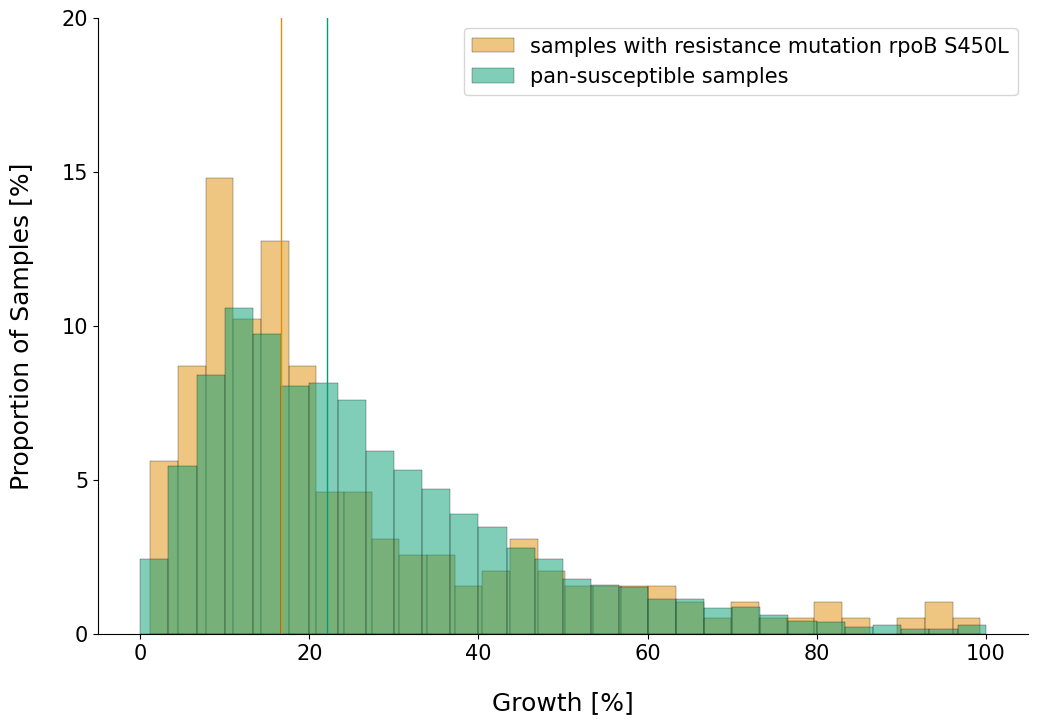

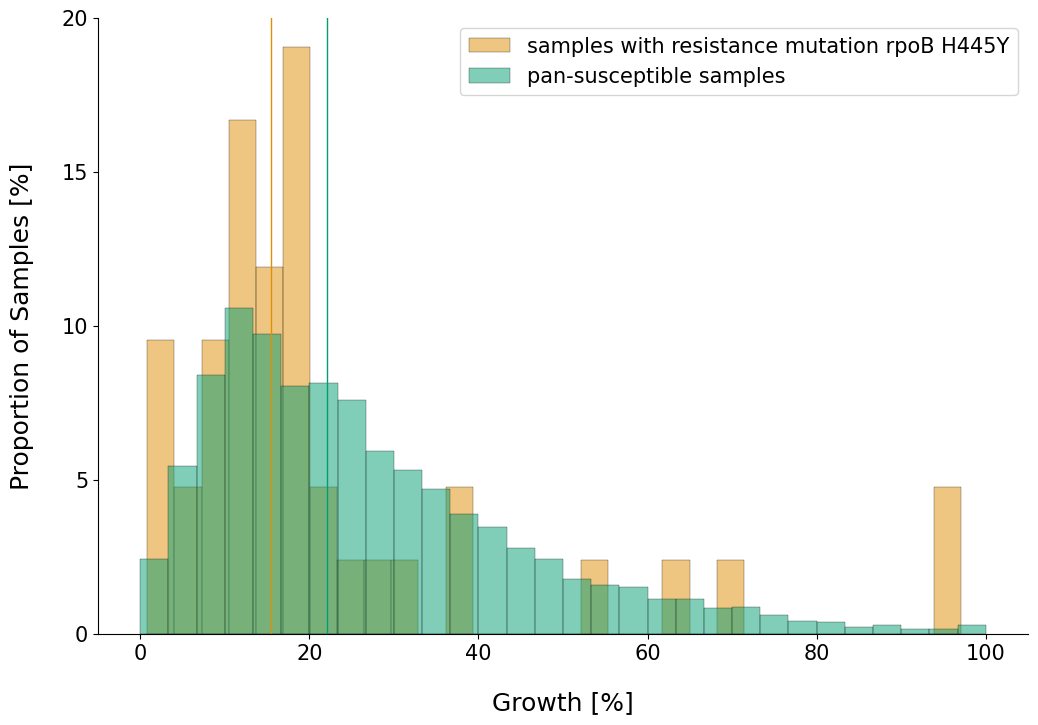

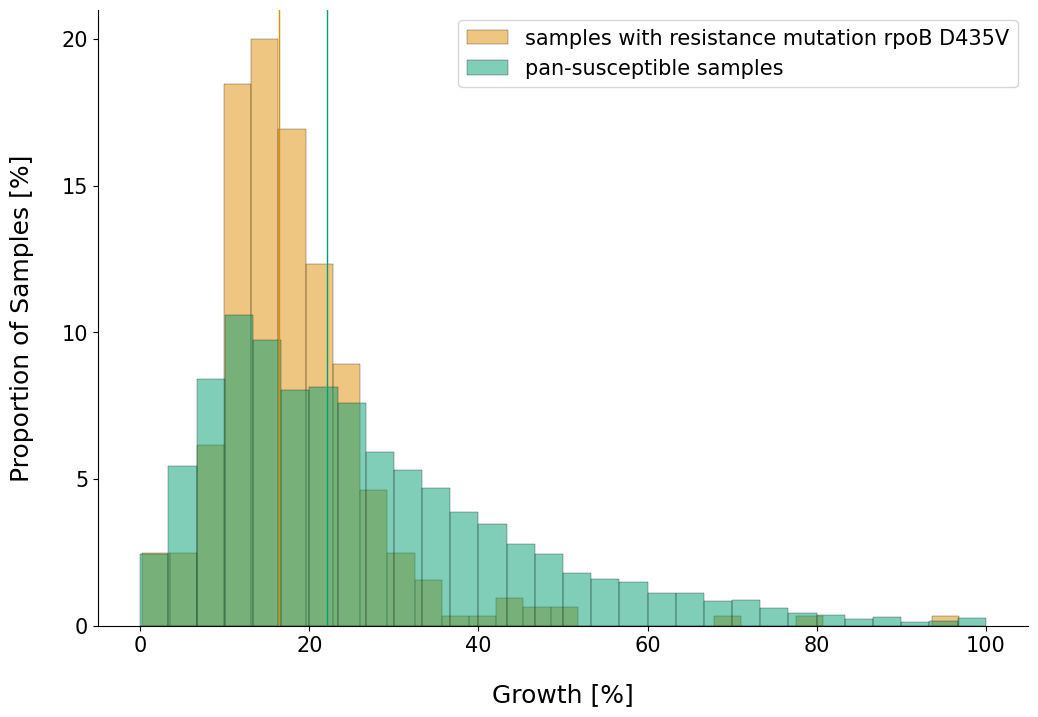

In [10]:
#load growth data for suscpetible UNIQUEIDs
susceptible = PLATES[(PLATES.UNIQUEID.isin(pan_sus_samples.values.tolist()))].IM_POS_AVERAGE
susceptible.dropna(inplace = True)

#fetch resistance mutations
res_gene_mutations = EFFECTS.GENE_MUTATION.unique()

#iterate through resistance mutations
for res in tqdm(res_gene_mutations):
    
    #query for samples with resistance and only synonymous other mutations
    spec_res = MUTATIONS[(MUTATIONS.GENE_MUTATION == res) & (MUTATIONS.UNIQUEID.isin(only_query))].UNIQUEID
    
    #load growth data for resistant UNIQUEIDs
    resistant = PLATES[(PLATES.UNIQUEID.isin(spec_res.values.tolist()))].IM_POS_AVERAGE
    resistant.dropna(inplace = True)
    
    #set reasonable prevalence cut-off for resistance mutation
    if len(resistant) < 40:
        continue
    
    #calculate p-value
    stat, p = mannwhitneyu(resistant, susceptible)
    
    #plot growth distributions below p-value cut-off
    if p < (0.05):
        
        fig, ax = plt.subplots()
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        fig.set_size_inches(12, 8)

        sns.histplot(data = resistant, bins = 30, alpha = 0.5, 
                     label="samples with resistance mutation " + res[0:4] + ' ' + res[5:], stat = "percent", 
                     color = colors[1], edgecolor='k', linewidth = 0.2)
        plt.axvline(resistant.median(), color = colors[1], linewidth = 1)
        
        sns.histplot(data = susceptible, bins = 30, alpha = 0.5, 
                     label="pan-susceptible samples", stat = "percent", 
                     color = colors[2], edgecolor='k', linewidth = 0.2)
        plt.axvline(susceptible.median(), color = colors[2], linewidth = 1)
        
        plt.xlabel("Growth [%]", size = 18, labelpad = 20)
        plt.ylabel("Proportion of Samples [%]", size = 18, labelpad = 20)
        
        plt.xticks(fontsize = 15)
        plt.yticks(numpy.arange(0, 21, 5.0), fontsize = 15)
        
        plt.legend(loc = 'upper right', fontsize = 15)

        # Uncomment this for creating figure:
        #fig.savefig('res_vs_sus_' + res + '.svg', format='svg', dpi=1200)
        

**Table 1:** 

Median growth of samples with and without indicated resistance mutations. The confidence interval (CI) for the median is calculated using bootstrapping where 'CI low' indicates the lower threshold and 'CI high' the upper threshold. Mann-Whitney p-value is calculated in reference to pan-susceptible sample growth and n indicates the sample size.

In [11]:
table = pandas.DataFrame(stats, columns = ['mutation','median growth [%]', 'CI low', 'CI high', 'p-value', 'mean growth [%]', 'n'], index = None)
table = table.drop(['mean growth [%]'], axis = 1)
print(table.to_latex(index = False))

\begin{tabular}{lrrrlr}
\toprule
mutation & median growth [%] & CI low & CI high & p-value & n \\
\midrule
pan-susceptible & 22.100000 & 21.600000 & 22.700000 &  & 5283 \\
any resistance & 17.570000 & 16.620000 & 18.540000 & 2.9538806538738147e-12 & 795 \\
rpoB S450L & 16.650000 & 15.220000 & 18.920000 & 0.004370955721574559 & 196 \\
rpoB H445Y & 15.500000 & 12.590000 & 19.480000 & 0.01260896272020915 & 42 \\
rpoB D435V & 16.400000 & 15.580000 & 17.190000 & 3.9207542608554665e-14 & 325 \\
\bottomrule
\end{tabular}



In [12]:
#query for samples with resistance and only synonymous other mutations
S450L = MUTATIONS[(MUTATIONS.GENE_MUTATION == 'rpoB_S450L') & (MUTATIONS.UNIQUEID.isin(only_query))].UNIQUEID
H445Y = MUTATIONS[(MUTATIONS.GENE_MUTATION == 'rpoB_H445Y') & (MUTATIONS.UNIQUEID.isin(only_query))].UNIQUEID
D435V = MUTATIONS[(MUTATIONS.GENE_MUTATION == 'rpoB_D435V') & (MUTATIONS.UNIQUEID.isin(only_query))].UNIQUEID

#load growth data for resistant UNIQUEIDs
S450L_growth = PLATES[(PLATES.UNIQUEID.isin(S450L.values.tolist()))].IM_POS_AVERAGE
H445Y_growth = PLATES[(PLATES.UNIQUEID.isin(H445Y.values.tolist()))].IM_POS_AVERAGE
D435V_growth = PLATES[(PLATES.UNIQUEID.isin(D435V.values.tolist()))].IM_POS_AVERAGE
S450L_growth.dropna(inplace = True)
H445Y_growth.dropna(inplace = True)
D435V_growth.dropna(inplace = True)

#calculate p-value
stat, p1 = mannwhitneyu(S450L_growth, H445Y_growth)
stat, p2 = mannwhitneyu(S450L_growth, D435V_growth)
stat, p3 = mannwhitneyu(H445Y_growth, D435V_growth)
print(p1,p2,p3)

S450L_boot = my_bootstrap(S450L_growth)
H445Y_boot = my_bootstrap(H445Y_growth)
D435V_boot = my_bootstrap(D435V_growth)

stats = []
stats.append(['rpoB S450L', S450L_boot [0], ' ', str(p1), str(p2), len(S450L_growth)])
stats.append(['rpoB H445Y', H445Y_boot [0], str(p1), ' ', str(p3), len(H445Y_growth)])
stats.append(['rpoB D435V', D435V_boot [0], str(p2), str(p3), ' ', len(D435V_growth)])
stats

0.41933081982114173 0.2664101196013515 0.6445360754311038


[['rpoB S450L', 16.65, ' ', '0.41933081982114173', '0.2664101196013515', 196],
 ['rpoB H445Y', 15.5, '0.41933081982114173', ' ', '0.6445360754311038', 42],
 ['rpoB D435V', 16.4, '0.2664101196013515', '0.6445360754311038', ' ', 325]]

In [13]:
table = pandas.DataFrame(stats, columns = ['mutation','median growth [%]', 'p_{S450L}', 'p_{H445Y}', 'p_{D435V}', 'n'], index = None)
print(table.to_latex(index = False))

\begin{tabular}{lrlllr}
\toprule
mutation & median growth [%] & p_{S450L} & p_{H445Y} & p_{D435V} & n \\
\midrule
rpoB S450L & 16.650000 &   & 0.41933081982114173 & 0.2664101196013515 & 196 \\
rpoB H445Y & 15.500000 & 0.41933081982114173 &   & 0.6445360754311038 & 42 \\
rpoB D435V & 16.400000 & 0.2664101196013515 & 0.6445360754311038 &   & 325 \\
\bottomrule
\end{tabular}



**Supplementary Figure S2:**

Sensitivity and number of significant hits (putative compensatory mutations) depending on p-value} The graph shows the number of significant hits and reference hits detected depending on the $\log_{10}$ p-value cutoff shown on the x-axis. The left y-axis refers to the percentage of found reference hits from a compiled list, also termed sensitivity or true positive rate (TPR). The right y-axis shows the number of mutations that were classified as significantly resistance associated under the respective cut-off. The vertical lines indicate the theoretical p-value cut-off with Bonferroni correction and the heuristic p-value cut-off at the 98$\%$ quantile, respectively.

7.556302500767288 25.88884352650637


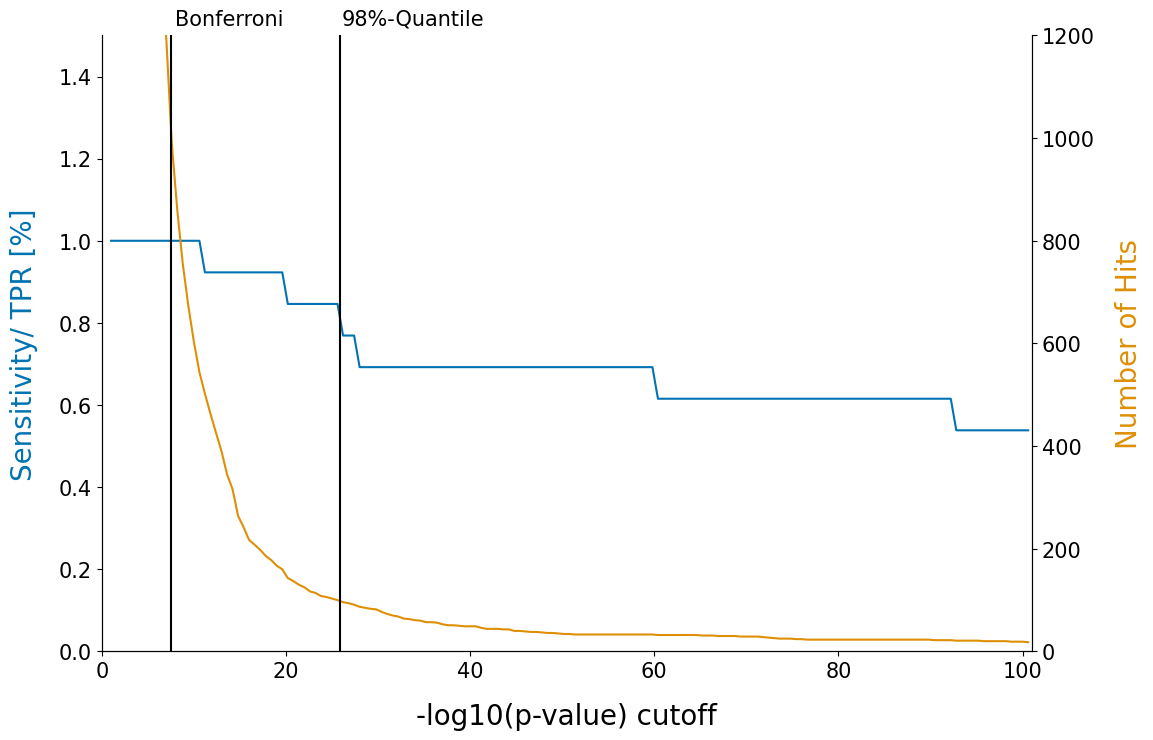

In [14]:
#set color palette
colors = sns.color_palette("colorblind")
my_cmap = ListedColormap(sns.color_palette(colors).as_hex())

#Obtain number of hits corresponding to cut-off
results_fisher = pandas.read_csv('fisher_all.csv')
results_fisher = results_fisher[results_fisher.both != 0]
results_fisher = results_fisher.iloc[:-1,:]
results_fisher['log10'] = -numpy.log10(results_fisher.p_value.astype('float'))
results = results_fisher

reference = pandas.read_excel(r'Ref_CMs.xlsx', 
                              sheet_name = 'conservative_CMs') #or 'conservative_CMs'
reference.drop([0,1,2,3], axis = 0, inplace = True)
reference.drop(index = reference.index[-2:], axis = 0, inplace = True)

n_refs = []
n_hits = []
cut_offs = numpy.arange(1, 101, 0.6).tolist() # list(range(1,101,0.5))
bonferroni_p = -numpy.log10(0.01/360000)

for i in cut_offs:
    
    results_tmp = results[results.log10 > i]
    ref_ratio = len(results_tmp[results_tmp.other_mutation.isin(reference.mutation)])/len(reference.mutation)
    
    if ref_ratio > 1:
        ref_ratio = 1
        
    n_refs.append(ref_ratio)
    n_hits.append(len(results[results.log10 > i])) #replace with len(results_tmp)

#plot graphs
fig, ax1 = plt.subplots()
fig.set_size_inches(12, 8)

ax1.spines["top"].set_visible(False)
ax1.tick_params(labelsize = 15)

ax1.set_xlim(0, 101)
ax1.set_ylim(0, 1.5)

ax1.set_xlabel('-log10(p-value) cutoff', size = 20, labelpad = 15)
ax1.set_ylabel('Sensitivity/ TPR [%]', size = 20, labelpad = 15)
ax1.yaxis.label.set_color(colors[0])

ax1.plot(cut_offs, n_refs, color = colors[0], label = 'reference hits')
#plt.plot(cutoff[3], n_refs[3], 'g*', markersize = 15)
ax1.tick_params(axis = 'y')
#ax1.legend(loc = 0, fontsize = 15)

ax2 = ax1.twinx()
ax2.spines["top"].set_visible(False)
ax2.tick_params(labelsize = 15)

ax2.set_ylim(0, 1200)

ax2.set_ylabel('Number of Hits', size = 20, labelpad = 15)
ax2.yaxis.label.set_color(colors[1])

ax2.plot(cut_offs, n_hits, color = colors[1], label = 'hits')
#plt.plot(cutoff[3], n_hits[3], 'g*', markersize = 15)
ax2.tick_params(axis = 'y')
#ax2.legend(loc = 0, fontsize = 15)

plt.axvline(x = bonferroni_p, color = 'black')
plt.axvline(x = numpy.quantile(results.log10, 0.98), color = 'black')

plt.text(8, 1220, 'Bonferroni', size = 15)
plt.text(26, 1220, '98%-Quantile', size = 15)

#Uncomment below save image:
#fig.savefig('P_value_cutoff.svg', format='svg', dpi=1200)
print(bonferroni_p, numpy.quantile(results.log10, 0.98))

**Supplementary Table S2:** 

Hit list resulting from Fisher’s exact test for association of resistance with co-occuring mutations, after removing synonymous mutations. The first column indicates the resistance mutation that the putative compensatory mutation (CM) in the second column is associated to. ’Only CM’ indicates how often the CM occurs on its own, without the corresponding resistance mutation, and ’both’ indicates how often we see the two mutations occur together. The last two columns indicate if the CM has been mentioned in the literature and if it shows homoplasy, respectively.

In [15]:
#read in hits from fisher test
hits_final = pandas.read_csv('fisher_all.csv')
hits_final = hits_final[hits_final.both != 0]
hits_final = hits_final.iloc[:-1,:]

hits_final['log10'] = -numpy.log10(hits_final.p_value.astype('float'))

#create list of all hits above the 98% quantile of p-values
hits_final = hits_final[(hits_final.log10 > numpy.quantile(hits_final.log10, 0.98))]
print('There are', len(hits_final.other_mutation.unique()), 'hits above the indicated p-value quantile')

#remove all hits that are synonymous mutations
hits_final = hits_final[~(hits_final.other_mutation.apply(lambda x: x[5]==x[-1]))]

hits_final = hits_final.sort_values('both', ascending = False)
hits_final = hits_final.drop(['None', 'resistant', 'n_resistant', 'n_other', 'p_value'], axis = 1)
hits_final.reset_index(drop = True, inplace = True)
print('Out of these hits,', len(hits_final.other_mutation.unique()), 'are non-synonymous')

##determine which hits are reference hits: -> this needs to be redone, since newest reference is not included?
#load reference data
reference = pandas.read_excel(r'Ref_CMs.xlsx', 
                              sheet_name = 'described_CMs_binary')
reference.drop([0,1,2,3], axis = 0, inplace = True)
reference.drop(index = reference.index[-2:], axis = 0, inplace = True)

print('Out of these', len(hits_final.other_mutation.unique()), 'non-synonymous hits,', len(hits_final[~hits_final.other_mutation.isin(reference['mutation'])].other_mutation.unique()), 'are novel CMs')

#add literature evidence column to final hit list
hits_final['literature evidence'] = hits_final.other_mutation.isin(reference['mutation'])
#hits_final['lit. evidence'] = ['\u2713' if x == True else '\u2717' for x in hits_final['lit. evidence']]

#add homoplasy column to final hit list (CM in at least two sub clades without common ancestors) [True, False, N/D (no data)]
no_homoplasy = pandas.read_csv('all_hits_concat.csv')
no_homoplasy = no_homoplasy[no_homoplasy.homoplasy == False].CM
hits_final['homoplasy'] = (~hits_final.other_mutation.isin(no_homoplasy))
#hits_final['homoplasy'] = ['\u2713' if x == False else '\u2717' for x in hits_final['homoplasy']]
print('Out of these', len(hits_final.other_mutation.unique()), 'non-synonymous hits,', len(hits_final[(hits_final.homoplasy == True)].other_mutation.unique()), 'show homoplasy, and', len(hits_final[(hits_final.homoplasy == True) & ~hits_final.other_mutation.isin(reference['mutation'])].other_mutation.unique()), 'show homoplasy and are novel CMs')

#show only hits with a combined prevalence of 10 or higher
#hits_final = hits_final[hits_final.both > 9]
#print('total CMs > 9:',len(hits_final.other_mutation.unique()))
hits_final = hits_final.rename(columns = {'resistant_mutation': 'resistance', 'other_mutation': 'putative CM', 'both': 'frequency'})

print(hits_final.to_latex(index = False))

There are 96 hits above the indicated p-value quantile
Out of these hits, 78 are non-synonymous
Out of these 78 non-synonymous hits, 38 are novel CMs
Out of these 78 non-synonymous hits, 51 show homoplasy, and 12 show homoplasy and are novel CMs
\begin{tabular}{llrrrrr}
\toprule
resistance & putative CM & other & frequency & log10 & literature evidence & homoplasy \\
\midrule
rpoB_S450L & rpoC_E1092D & 2012 & 1989 & inf & False & False \\
rpoB_S450L & rpoC_V483G & 37 & 1206 & inf & True & True \\
rpoB_S450L & rpoC_I491V & 19 & 665 & inf & True & True \\
rpoB_S450L & rpoC_V483A & 33 & 586 & inf & True & True \\
rpoB_S450L & rpoC_I491T & 10 & 457 & 293.055074 & True & True \\
rpoB_S450L & rpoC_P1040R & 32 & 396 & 225.093082 & True & True \\
rpoB_S450L & rpoC_F452S & 2 & 345 & 230.575216 & True & True \\
rpoB_S450L & rpoB_E761D & 0 & 304 & 207.047893 & False & False \\
rpoB_S450L & rpoB_L731P & 1 & 226 & 151.442572 & True & True \\
rpoB_S450L & rpoC_N698S & 2 & 205 & 135.233842 & True & T

In [16]:
hits_final[hits_final.homoplasy == True].resistance.value_counts()

resistance
rpoB_S450L    47
rpoB_I491F     1
rpoB_H445R     1
rpoB_H445D     1
rpoB_D435G     1
Name: count, dtype: int64

**Figure 3: Putative CMs are distributed widely across the phylogenetic tree and the genome**

**Figure 3(A):** 

Phylogenetic tree was constructed from newick format using the iTOL software: https://itol.embl.de

The newick file and all annotation files are provided in the github repository in the folder "phylogeny".

**Figure 3(B):** 

The putative CMs were mapped according to their position in the respective gene. There were five hits on the $\sigma$ factor that are not shown, as well as one hit on the rpoZ gene. All of these do not show homoplasy. E1092D is outside of the plotting range due to its high frequency.

In [17]:
rpoA_hits = []
rpoB_hits = []
rpoC_hits = []
rpoZ_hits = []
sigA_hits = []

for i in range(0,len(hits_final)):
    
    gene = hits_final['putative CM'][i][:4]
    
    if gene == 'rpoA':
        rpoA_hits.append(hits_final.iloc[i])
        
    elif gene == 'rpoB':
        rpoB_hits.append(hits_final.iloc[i])
        
    elif gene == 'rpoC':
        rpoC_hits.append(hits_final.iloc[i])
        
    elif gene == 'rpoZ':
        rpoZ_hits.append(hits_final.iloc[i])
        
    elif gene == 'sigA':
        sigA_hits.append(hits_final.iloc[i])
        
    else:
        print('error')
    
rpoA_hits = pandas.DataFrame(rpoA_hits)
rpoB_hits = pandas.DataFrame(rpoB_hits)
rpoC_hits = pandas.DataFrame(rpoC_hits)
rpoZ_hits = pandas.DataFrame(rpoZ_hits)
sigA_hits = pandas.DataFrame(sigA_hits)

rpoA_hits.drop(rpoA_hits[rpoA_hits['putative CM'].str.contains('indel')].index, inplace = True)
sigA_hits.drop(sigA_hits[sigA_hits['putative CM'].str.contains('indel')].index, inplace = True)
hits_final.drop(hits_final[hits_final['putative CM'].str.contains('indel')].index, inplace = True)

def create_label(row):
    
    return int(row['putative CM'][6:-1])

rpoA_hits['LABEL'] = rpoA_hits.apply(create_label, axis=1)
rpoB_hits['LABEL'] = rpoB_hits.apply(create_label, axis=1)
rpoC_hits['LABEL'] = rpoC_hits.apply(create_label, axis=1)
rpoZ_hits['LABEL'] = rpoZ_hits.apply(create_label, axis=1)
sigA_hits['LABEL'] = sigA_hits.apply(create_label, axis=1)
hits_final['LABEL'] = hits_final.apply(create_label, axis=1)

#replace frequency value of E1092D to fit it in plot (frequency out of range)
rpoC_hits.frequency[rpoC_hits['putative CM'] == 'rpoC_E1092D'] = 1200
rpoC_hits = rpoC_hits.sort_values(by='LABEL', ascending = True)

print('done')

done


Mapping on rpoC

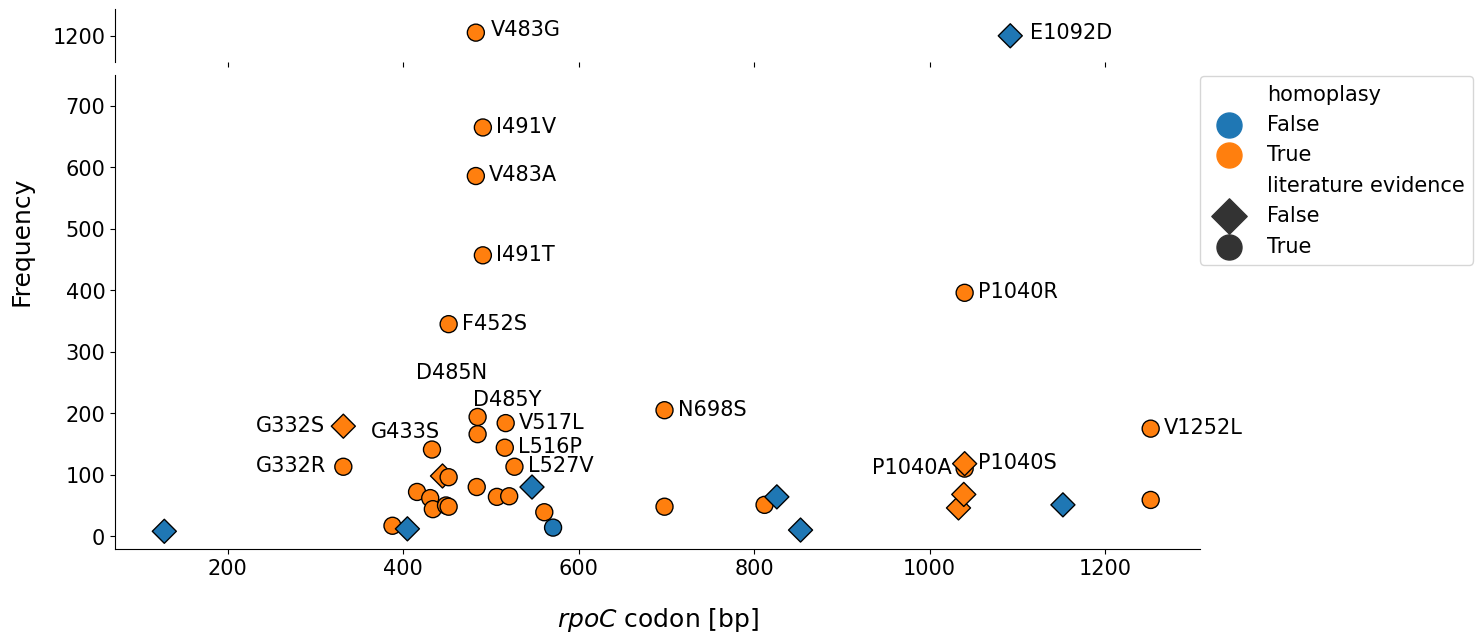

In [18]:
markers = {True:'o', False:'D'}

fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, sharex=True, 
                               gridspec_kw = {"height_ratios": (0.1, 0.9)})

fig.subplots_adjust(hspace=0.05, wspace=0.125)

#fig, ax = plt.subplots(1)
axes = [ax1, ax2]

for ax in axes:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    
#ax.xaxis.set_major_locator(plt.NullLocator())
    
fig.set_size_inches(14, 7)

ax1 = sns.scatterplot(x = rpoC_hits['LABEL'], y = rpoC_hits['frequency'], style = rpoC_hits['literature evidence'], 
                hue = rpoC_hits['homoplasy'], s = 150, markers = markers, edgecolor = 'black', ax=ax1)
ax2 = sns.scatterplot(x = rpoC_hits['LABEL'], y = rpoC_hits['frequency'], style = rpoC_hits['literature evidence'], 
                hue = rpoC_hits['homoplasy'], s = 150, markers = markers, edgecolor = 'black', ax=ax2)

for i, name in enumerate (rpoC_hits['putative CM']):
    
    if rpoC_hits.iloc[i]['frequency'] < 100:
        plt.text(rpoC_hits.iloc[i]['LABEL'], rpoC_hits.iloc[i]['frequency'], '', size = 15)
    
    elif name[5:] == 'P1040A' and rpoC_hits.iloc[i]['frequency'] > 100:
        plt.text(rpoC_hits.iloc[i]['LABEL']-105, rpoC_hits.iloc[i]['frequency']-8, name[5:], size = 15)
        
    elif name[5:] == 'G433S' and rpoC_hits.iloc[i]['frequency'] > 100:
        plt.text(rpoC_hits.iloc[i]['LABEL']-70, rpoC_hits.iloc[i]['frequency']+20, name[5:], size = 15)
    
    elif name[5:] == 'D485Y' and rpoC_hits.iloc[i]['frequency'] > 100:
        plt.text(rpoC_hits.iloc[i]['LABEL']-5, rpoC_hits.iloc[i]['frequency']+19, name[5:], size = 15)
        
    elif name[5:] == 'D485N' and rpoC_hits.iloc[i]['frequency'] > 100:
        plt.text(rpoC_hits.iloc[i]['LABEL']-70, rpoC_hits.iloc[i]['frequency']+90, name[5:], size = 15)
        
    elif name[5:] == 'G332S' and rpoC_hits.iloc[i]['frequency'] > 100:
        plt.text(rpoC_hits.iloc[i]['LABEL']-100, rpoC_hits.iloc[i]['frequency']-8, name[5:], size = 15)
        
    elif name[5:] == 'G332R' and rpoC_hits.iloc[i]['frequency'] > 100:
        plt.text(rpoC_hits.iloc[i]['LABEL']-100, rpoC_hits.iloc[i]['frequency']-8, name[5:], size = 15)
        
    elif name[5:] == 'V483G' and rpoC_hits.iloc[i]['frequency'] > 100:
        plt.text(500, 815, name[5:], size = 15)
        
    elif name[5:] == 'E1092D' and rpoC_hits.iloc[i]['frequency'] > 100:
        plt.text(1115, 810, name[5:], size = 15)
    
    else:
        plt.text(rpoC_hits.iloc[i]['LABEL']+15, rpoC_hits.iloc[i]['frequency']-8, name[5:], size = 15)
    
#ax1.legend(fontsize=20, markerscale = 3, loc = [0.7, 0.5])
#ax.yaxis.set_label_coords(-0.07, 0.35)
#plt.xticks(rotation=90)
ax1.set_ylim(1150, 1250)
ax2.set_ylim(-20, 750)

ax2.spines["bottom"].set_visible(True)
#ax2.set_xticklabels([0, 200, 400, 600, 800, 1000, 1200], fontsize = 15)

ax1.set_ylabel("")
ax2.set_ylabel("")

fig.text(0.05, 0.55, "Frequency", size = 18, va="center", rotation="vertical")

ax1.get_legend().remove()
ax2.get_legend().remove()
ax2.legend(fontsize=15, markerscale = 3, loc = [1, 0.6])

plt.xlabel('$\mathit{rpoC}$ codon [bp]', size = 18, labelpad = 20)
#plt.ylabel("Frequency", size = 18, labelpad = 20)

plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
ax1.set_yticklabels([1150,1200,1250], fontsize = 15)

import matplotlib.ticker as ticker
ax1.yaxis.set_major_locator(ticker.MultipleLocator(100))
#ax2.xaxis.set_major_locator(ticker.MultipleLocator(200))

#fig.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.95)

#Uncomment below save image:
#fig.savefig('CMs_genome_rpoC.svg', format='svg', dpi=1200)

Mapping on rpoA

(array([-25.,   0.,  25.,  50.,  75., 100., 125., 150., 175., 200.]),
 [Text(0, -25.0, '−25'),
  Text(0, 0.0, '0'),
  Text(0, 25.0, '25'),
  Text(0, 50.0, '50'),
  Text(0, 75.0, '75'),
  Text(0, 100.0, '100'),
  Text(0, 125.0, '125'),
  Text(0, 150.0, '150'),
  Text(0, 175.0, '175'),
  Text(0, 200.0, '200')])

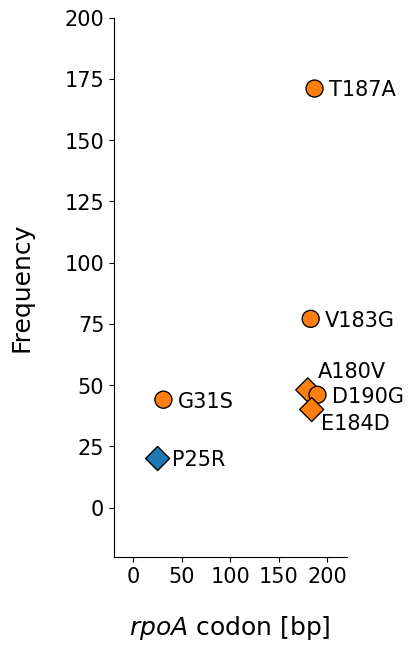

In [19]:
markers = {True:'o', False:'D'}

fig, ax = plt.subplots(1)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.set_size_inches(3, 7)

sns.scatterplot(x = rpoA_hits['LABEL'], y = rpoA_hits['frequency'], style = rpoA_hits['literature evidence'], 
                hue = rpoA_hits['homoplasy'], s = 150, markers = markers, edgecolor = 'black', legend = False)

for i, name in enumerate (rpoA_hits['putative CM']):
    
    if rpoA_hits.iloc[i]['frequency'] < 5:
        plt.text(rpoA_hits.iloc[i]['LABEL'], rpoA_hits.iloc[i]['frequency'], '', size = 15)
        
    elif name[5:] == 'A180V' and rpoA_hits.iloc[i]['frequency'] > 45:
        plt.text(rpoA_hits.iloc[i]['LABEL']+10, rpoA_hits.iloc[i]['frequency']+5, name[5:], size = 15)
        
    elif name[5:] == 'E184D':
        plt.text(rpoA_hits.iloc[i]['LABEL']+10, rpoA_hits.iloc[i]['frequency']-8, name[5:], size = 15)
        
    else:
        plt.text(rpoA_hits.iloc[i]['LABEL']+15, rpoA_hits.iloc[i]['frequency']-3, name[5:], size = 15)

#ax.legend(fontsize=20, markerscale = 3)
#plt.xticks(rotation=90)
plt.ylim(-20,200)
plt.xlim(-20,220)

plt.xlabel('$\mathit{rpoA}$ codon [bp]', size = 18, labelpad = 20)
plt.ylabel("Frequency", size = 18, labelpad = 22)

plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

#Uncomment below save image:
#fig.savefig('CMs_genome_rpoA.svg', format='svg', dpi=1200, bbox_inches='tight')

Mapping on rpoB

(array([-50.,   0.,  50., 100., 150., 200., 250., 300., 350.]),
 [Text(0, -50.0, '−50'),
  Text(0, 0.0, '0'),
  Text(0, 50.0, '50'),
  Text(0, 100.0, '100'),
  Text(0, 150.0, '150'),
  Text(0, 200.0, '200'),
  Text(0, 250.0, '250'),
  Text(0, 300.0, '300'),
  Text(0, 350.0, '350')])

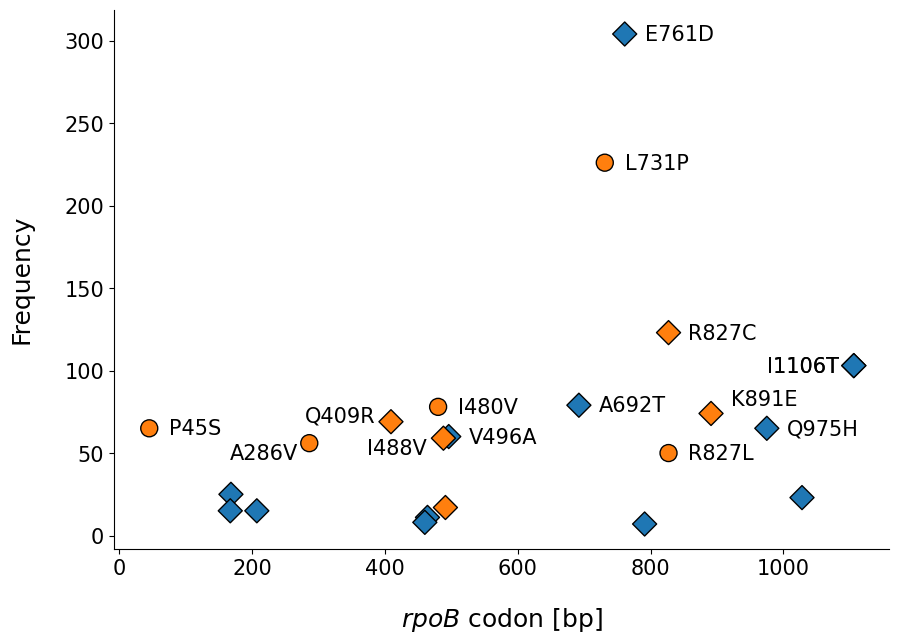

In [20]:
markers = {True:'o', False:'D'}

fig, ax = plt.subplots(1)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.set_size_inches(10, 7)

sns.scatterplot(x = rpoB_hits['LABEL'], y = rpoB_hits['frequency'], style = rpoB_hits['literature evidence'], 
                hue = rpoB_hits['homoplasy'], s = 150, markers = markers, edgecolor = 'black', legend = False)

for i, name in enumerate (rpoB_hits['putative CM']):
    
    if rpoB_hits.iloc[i]['frequency'] < 50:
        plt.text(rpoC_hits.iloc[i]['LABEL'], rpoC_hits.iloc[i]['frequency'], '', size = 15)      
        
    elif name[5:] == 'A286V':
        plt.text(rpoB_hits.iloc[i]['LABEL']-120, rpoB_hits.iloc[i]['frequency']-10, name[5:], size = 15)
        
    elif name[5:] == 'Q409R':
        plt.text(rpoB_hits.iloc[i]['LABEL']-130, rpoB_hits.iloc[i]['frequency'], name[5:], size = 15)
    
    elif name[5:] == 'K891E':
        plt.text(rpoB_hits.iloc[i]['LABEL']+30, rpoB_hits.iloc[i]['frequency']+5, name[5:], size = 15)
        
    elif name[5:] == 'I488V':
        plt.text(rpoB_hits.iloc[i]['LABEL']-115, rpoB_hits.iloc[i]['frequency']-10, name[5:], size = 15)
        
    elif name[5:] == 'V695L':
        plt.text(rpoB_hits.iloc[i]['LABEL']+30, rpoB_hits.iloc[i]['frequency']+2, name[5:], size = 15)
        
    elif name[5:] == 'I1106T':
        plt.text(rpoB_hits.iloc[i]['LABEL']-130, rpoB_hits.iloc[i]['frequency']-4, name[5:], size = 15)
            
    else:
        plt.text(rpoB_hits.iloc[i]['LABEL']+30, rpoB_hits.iloc[i]['frequency']-4, name[5:], size = 15)

#ax.legend(fontsize=20, markerscale = 3)
#plt.xticks(rotation=90)
#plt.ylim(-20,150)
#plt.xlim(-20,220)

plt.xlabel('$\mathit{rpoB}$ codon [bp]', size = 18, labelpad = 20)
plt.ylabel("Frequency", size = 18, labelpad = 22)

plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

#Uncomment below save image:
#fig.savefig('CMs_genome_rpoB.svg', format='svg', dpi=1200)

**Figure 4: Compensatory mutations (CMs) map to various subunits of the RNA polymerase (RNAP)**

Performed outside of this notebook, we mapped the list of homoplastic, non-synonymous hits onto a PyMOL structure of the M. tuberculosis RNA polymerase with bound Rifampicin. The crystal structure for the PyMOL file was obtained by Lin et al (pdb: 5UHB).

**Figure 5: Growth and lineage distributions of M. tuberculosis samples that are pan-susceptible, rifampicin (RIF) resistant and resistant with compensatory mutations (CMs)**

**Figure 5(A):** 

Distributions of growth in percent of covered well-area as measured in the CRyPTIC project (Foweler et al, 2018) were plotted as a histogram against the proportion of samples that display this amount of growth (bottom) and as a notched box plot reflecting the distribution quantiles (top). Samples with RIF resistance mutations but no putative CMs are plotted in red, samples that were classified as pan-susceptible are plotted in green. Samples that have RIF resistance mutations and at least one CM are shown in blue. For the box plot, half of the data lies within the area of the box and 95$\%$ in the area covered by the whiskers. Outliers (5 % of the data) were removed to achieve a cleaner representation. Indented area close to the medians indicate their respective confidence interval, while the star (*) indicates a significant Mann-Whitney p-value (p < 0.05 %). The respective medians, confidence intervals and the Mann-Whitney p-values are listed in Supplementary Table S4.

There are 96 hits above the indicated p-value quantile
Out of these hits, 78 are non-synonymous
Out of these 78 non-synonymous hits, 51 show homoplasy
Out of these 51 non-synonymous, homoplastic hits, 12 are novel CMs


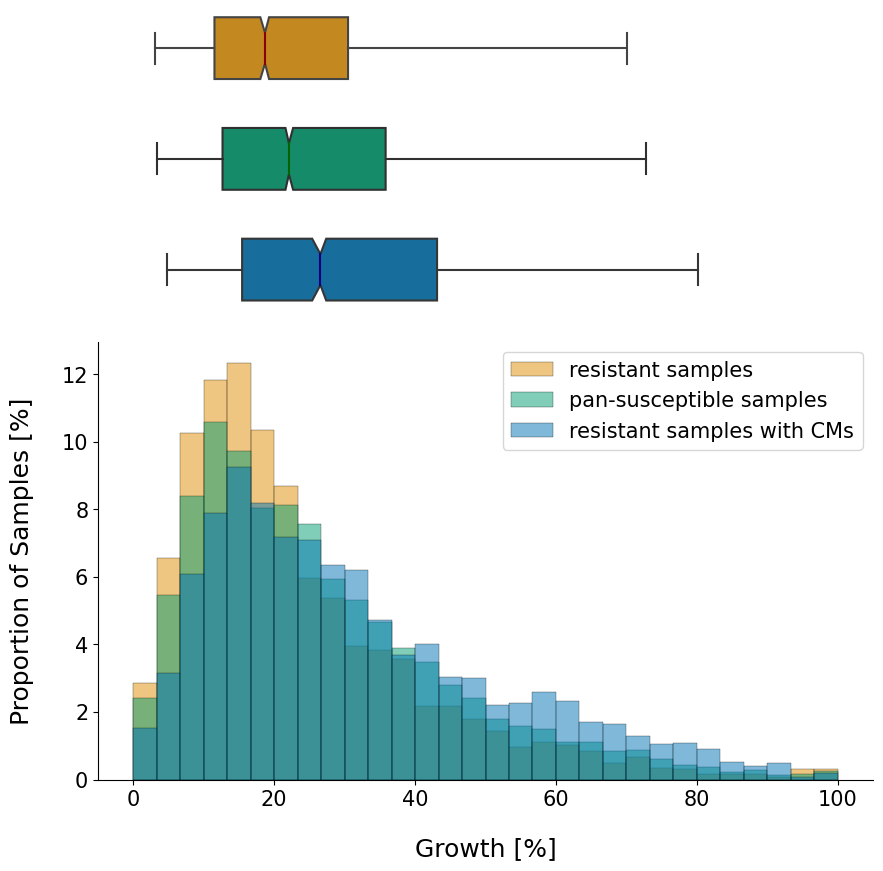

In [21]:
hits_final = pandas.read_csv('fisher_all.csv')
hits_final = hits_final[hits_final.both != 0]
hits_final = hits_final.iloc[:-1,:]

hits_final['log10'] = -numpy.log10(hits_final.p_value.astype('float'))

#create list of all hits above the 98% quantile of p-values
hits_final = hits_final[(hits_final.log10 > numpy.quantile(hits_final.log10, 0.98))]
print('There are', len(hits_final.other_mutation.unique()), 'hits above the indicated p-value quantile')

#remove all hits that are synonymous mutations
hits_final = hits_final[~(hits_final.other_mutation.apply(lambda x: x[5]==x[-1]))]

hits_final = hits_final.sort_values('both', ascending = False)
hits_final = hits_final.drop(['None', 'resistant', 'n_resistant', 'n_other', 'p_value'], axis = 1)
hits_final.reset_index(drop = True, inplace = True)
print('Out of these hits,', len(hits_final.other_mutation.unique()), 'are non-synonymous')

##determine which hits are reference hits: -> this needs to be redone, since newest reference is not included?
#load reference data
reference = pandas.read_excel(r'Ref_CMs.xlsx', 
                              sheet_name = 'described_CMs_binary')
reference.drop([0,1,2,3], axis = 0, inplace = True)
reference.drop(index = reference.index[-2:], axis = 0, inplace = True)

#add literature evidence column to final hit list
hits_final['literature evidence'] = hits_final.other_mutation.isin(reference['mutation'])
#hits_final['lit. evidence'] = ['\u2713' if x == True else '\u2717' for x in hits_final['lit. evidence']]

#add homoplasy column to final hit list (CM in at least two sub clades without common ancestors) [True, False, N/D (no data)]
no_homoplasy = pandas.read_csv('all_hits_concat.csv')
no_homoplasy = no_homoplasy[no_homoplasy.homoplasy == False].CM
hits_final['homoplasy'] = (~hits_final.other_mutation.isin(no_homoplasy))

print('Out of these', len(hits_final.other_mutation.unique()), 'non-synonymous hits,', 
      len(hits_final[hits_final.homoplasy == True].other_mutation.unique()), 'show homoplasy')

print('Out of these', len(hits_final[hits_final.homoplasy == True].other_mutation.unique()), 'non-synonymous, homoplastic hits,', 
      len(hits_final[(~hits_final.other_mutation.isin(reference['mutation'])) & (hits_final.homoplasy == True)].other_mutation.unique()), 'are novel CMs')


#set color palette
colors = palette("colorblind")

#load UNIQUEIDs of resistant samples with CMs
res_CM_samples = []

for i, name in enumerate(hits_final.resistant_mutation.unique()):
    resistance = MUTATIONS[(MUTATIONS.GENE_MUTATION == name)].UNIQUEID
    hit_samples_local = MUTATIONS[(MUTATIONS.GENE_MUTATION.isin(hits_final.other_mutation.values.tolist())) 
                                  & (MUTATIONS.UNIQUEID.isin(resistance.tolist()))].UNIQUEID.unique()
    res_CM_samples.append(hit_samples_local)

res_CM_samples = numpy.concatenate(res_CM_samples)
res_CM_samples = pandas.Series(res_CM_samples)

#load UNIQUEIDs of resistant samples without CMs
res_samples = EFFECTS[~(EFFECTS.UNIQUEID.isin(res_CM_samples))].UNIQUEID.values.tolist()
res_samples = pandas.Series(res_samples)

#load growth data for susceptible UNIQUEIDs
susceptible = PLATES[(PLATES.UNIQUEID.isin(pan_sus_samples.values.tolist()))].IM_POS_AVERAGE
susceptible.dropna(inplace = True)

#load growth data for resistant UNIQUEIDs
resistant = PLATES[(PLATES.UNIQUEID.isin(res_samples.values.tolist()))].IM_POS_AVERAGE
resistant.dropna(inplace = True)

#load growth data for resistant with CMs UNIQUEIDs
resistant_CM = PLATES[(PLATES.UNIQUEID.isin(res_CM_samples.values.tolist()))].IM_POS_AVERAGE
resistant_CM.dropna(inplace = True)

#calculate p-values
stat1, p1 = mannwhitneyu(resistant, susceptible)
stat2, p2 = mannwhitneyu(resistant, resistant_CM)
stat3, p3 = mannwhitneyu(resistant_CM, susceptible)

#save p-value and median
stats = []
sus_boot = my_bootstrap(susceptible)
stats.append(['pan-susceptible', sus_boot[0], sus_boot[1][0], sus_boot[1][1], '', '', 
              round(numpy.mean(susceptible), 2), len(susceptible)])

res_boot = my_bootstrap(resistant)
stats.append(['resistant and no CMs', res_boot[0], res_boot[1][0], res_boot[1][1], '', str(p1), 
              round(numpy.mean(resistant), 2), len(resistant)], )

resCM_boot = my_bootstrap(resistant_CM)
stats.append(['resistant and CMs', resCM_boot[0], resCM_boot[1][0], resCM_boot[1][1], 
              str(p2), str(p3), round(numpy.mean(resistant_CM), 2), len(resistant_CM)])

#Plot histograms with boxplots

fig, (ax_box1, ax_box2, ax_box3, ax_hist) = plt.subplots(4, sharex = True, 
                                                gridspec_kw = {"height_ratios": (0.15, 0.15, 0.15, 0.85)})

fig.set_size_inches(10, 10)

sns.histplot(data = resistant, label="resistant samples", color = colors[1], **hist_args)

sns.histplot(data = susceptible, label="pan-susceptible samples", color = colors[2], **hist_args)

sns.histplot(data = resistant_CM, label="resistant samples with CMs", color = colors[0], **hist_args)
    
sns.boxplot(resistant.to_list(), ax = ax_box1, color = colors[1], medianprops={"color": "darkred"}, 
            usermedians = [res_boot[0]], conf_intervals = [res_boot[1]], **box_args)  
sns.boxplot(susceptible.to_list(), ax = ax_box2, color = colors[2], medianprops={"color": "darkgreen"}, 
            usermedians = [sus_boot[0]], conf_intervals = [sus_boot[1]],**box_args)
sns.boxplot(resistant_CM.to_list(), ax = ax_box3, color = colors[0], medianprops={"color": "darkblue"}, 
            usermedians = [resCM_boot[0]], conf_intervals = [resCM_boot[1]],**box_args)

#Despine plots
sns.despine(top = True, right=True, left = False, bottom = False, offset = False, trim = False)

axes = [ax_box1, ax_box2, ax_box3]
for ax in axes:
    sns.despine(ax = ax, top = True, right=True, left = True, bottom = True, offset = False, trim = False)
    ax.tick_params(left=False, bottom=False) 
    ax.set(yticklabels=[])
    ax.set(xlabel='')

#Label plot
plt.xlabel("Growth [%]", size = 18, labelpad = 20)
plt.xticks(fontsize = 15)
plt.ylabel("Proportion of Samples [%]", size = 18, labelpad = 20)
plt.yticks(fontsize = 15)
plt.legend(loc = 'upper right', fontsize = 15)

# Uncomment this for creating figure:
fig.savefig('res_vs_sus_vs_CM.svg', format='svg', dpi=1200)

**Supplementary Table S3:**

Median growth of resistant samples with compensatory mutations compared to susceptible samples and samples with only resistance mutations. The confidence interval (CI) for the median is calculated using bootstrapping where 'CI low' indicates the lower threshold and 'CI high' the upper threshold. P-values are given with respect to resistant (p-value$_{r}$) and susceptible sample growth (p-value$_{s}$) and n indicates the sample size.

In [22]:
table = pandas.DataFrame(stats, columns = ['sample type','median growth [%]', 'CI low', 'CI high', 'p-value to res', 'p-value to sus', 'mean growth [%]', 'n'], index = None)
table = table.drop(['mean growth [%]'], axis = 1)
print(table.to_latex(index = False))

\begin{tabular}{lrrrllr}
\toprule
sample type & median growth [%] & CI low & CI high & p-value to res & p-value to sus & n \\
\midrule
pan-susceptible & 22.100000 & 21.610000 & 22.690000 &  &  & 5283 \\
resistant and no CMs & 18.700000 & 18.040000 & 19.280000 &  & 3.923414560593745e-15 & 2869 \\
resistant and CMs & 26.570000 & 25.400000 & 27.390000 & 3.915044367835579e-57 & 6.256446828808955e-26 & 2667 \\
\bottomrule
\end{tabular}



**Figure 5(B):** 

Plot structure equivalent to the box plot in A, but the bars represent pan-susceptible samples from different lineages, plotted in the respective colours indicated in the legend. The respective medians, confidence intervals and the Mann-Whitney p-value are listed in Supplementary Table S4.

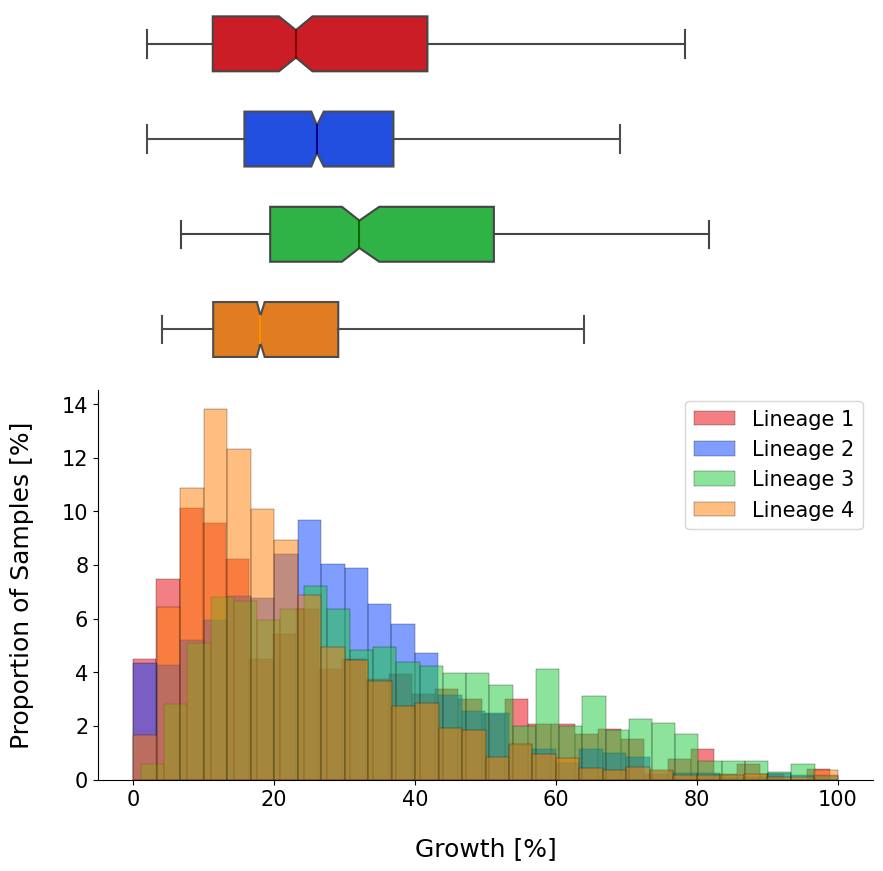

In [23]:
#set color palette
colors = palette("bright")

condition = GENOMES.WGS_PREDICTION_STRING.str[0:4].isin(['SSSS'])

#load growth data for lineages
lineage1 = GENOMES[(condition) & (GENOMES.MYKROBE_LINEAGE_NAME_1 == 'Lineage 1')].index.to_series()
data1 = PLATES[(PLATES.UNIQUEID.isin(lineage1.values.tolist()))].IM_POS_AVERAGE
data1.dropna(inplace = True)

lineage2 = GENOMES[(condition) & (GENOMES.MYKROBE_LINEAGE_NAME_1 == 'Lineage 2')].index.to_series()
data2 = PLATES[(PLATES.UNIQUEID.isin(lineage2.values.tolist()))].IM_POS_AVERAGE
data2.dropna(inplace = True)

lineage3 = GENOMES[(condition) & (GENOMES.MYKROBE_LINEAGE_NAME_1 == 'Lineage 3')].index.to_series()
data3 = PLATES[(PLATES.UNIQUEID.isin(lineage3.values.tolist()))].IM_POS_AVERAGE
data3.dropna(inplace = True)

lineage4 = GENOMES[(condition) & (GENOMES.MYKROBE_LINEAGE_NAME_1 == 'Lineage 4')].index.to_series()
data4 = PLATES[(PLATES.UNIQUEID.isin(lineage4.values.tolist()))].IM_POS_AVERAGE
data4.dropna(inplace = True)

#calculate p-values
stat1, p1 = mannwhitneyu(data1, data2)
stat2, p2 = mannwhitneyu(data1, data3)
stat3, p3 = mannwhitneyu(data1, data4)
stat4, p4 = mannwhitneyu(data2, data3)
stat5, p5 = mannwhitneyu(data2, data4)
stat6, p6 = mannwhitneyu(data3, data4)

#save median and CIs
stats = []

lin1_boot = my_bootstrap(data1)
stats.append(['Lineage 1', lin1_boot[0], lin1_boot[1][0], lin1_boot[1][1], '', '', '', '', len(data1)])

lin2_boot = my_bootstrap(data2)
stats.append(['Lineage 2', lin2_boot[0], lin2_boot[1][0], lin2_boot[1][1], str(p1), '', '', '', len(data2)])

lin3_boot = my_bootstrap(data3)
stats.append(['Lineage 3', lin3_boot[0], lin3_boot[1][0], lin3_boot[1][1], str(p2), str(p4), '', '', len(data3)])

lin4_boot = my_bootstrap(data4)
stats.append(['Lineage 4', lin4_boot[0], lin4_boot[1][0], lin4_boot[1][1], str(p3), str(p5), str(p6), '', len(data4)])

#Plot histograms with boxplots
fig, (ax_box1, ax_box2, ax_box3, ax_box4, ax_hist) = plt.subplots(5, sharex = True, 
                                                gridspec_kw = {"height_ratios": (0.15, 0.15, 0.15, 0.15, 0.85)})

fig.set_size_inches(10, 10)

sns.histplot(data = data1, label="Lineage 1", color = colors[3], **hist_args)

sns.histplot(data = data2, label="Lineage 2", color = colors[0], **hist_args)

sns.histplot(data = data3, label="Lineage 3", color = colors[2], **hist_args)

sns.histplot(data = data4, label="Lineage 4", color = colors[1], **hist_args)

sns.boxplot(data1.to_list(), ax = ax_box1, color = colors[3], medianprops={"color": "darkred"},
            usermedians = [lin1_boot[0]], conf_intervals = [lin1_boot[1]],**box_args)   
sns.boxplot(data2.to_list(), ax = ax_box2, color = colors[0], medianprops={"color": "darkblue"},
            usermedians = [lin2_boot[0]], conf_intervals = [lin2_boot[1]], **box_args)  
sns.boxplot(data3.to_list(), ax = ax_box3, color = colors[2], medianprops={"color": "darkgreen"}, 
            usermedians = [lin3_boot[0]], conf_intervals = [lin3_boot[1]],**box_args)
sns.boxplot(data4.to_list(), ax = ax_box4, color = colors[1], medianprops={"color": "darkorange"},
            usermedians = [lin4_boot[0]], conf_intervals = [lin4_boot[1]],**box_args)

#Despine plots
sns.despine(top = True, right=True, left = False, bottom = False, offset = False, trim = False)

axes = [ax_box1, ax_box2, ax_box3, ax_box4]
for ax in axes:
    sns.despine(ax = ax, top = True, right=True, left = True, bottom = True, offset = False, trim = False)
    ax.tick_params(left=False, bottom=False) 
    ax.set(yticklabels=[])
    ax.set(xlabel='')

plt.xlabel("Growth [%]", size = 18, labelpad = 20)
plt.xticks(fontsize = 15)
plt.ylabel("Proportion of Samples [%]", size = 18, labelpad = 20)
plt.yticks(fontsize = 15)
plt.legend(loc = 'upper right', fontsize = 15)

# uncomment below to save image:
#fig.savefig('lineages_growth.svg', format='svg', dpi=1200)

**Supplementary Table S4:**

Median growth of pan-susceptible samples from different M. tuberculosis lineages. The confidence interval (CI) for the median is calculated using bootstrapping where 'CI low' indicates the lower threshold and 'CI high' the upper threshold. P-values are given with respect to each lineage, indicated by the subscript x (p-value$_{x}$) and n indicates the sample size.

In [24]:
table = pandas.DataFrame(stats, columns = ['Lineage', 'median growth [%]', 'CI low', 'CI high', 'p-value to 1', 'p-value to 2', 'p-value to 3', 'p-value to 4','n'], index = None)

print(table.to_latex(index = False))

\begin{tabular}{lrrrllllr}
\toprule
Lineage & median growth [%] & CI low & CI high & p-value to 1 & p-value to 2 & p-value to 3 & p-value to 4 & n \\
\midrule
Lineage 1 & 23.090000 & 20.680000 & 25.440000 &  &  &  &  & 534 \\
Lineage 2 & 26.080000 & 25.280000 & 27.040000 & 0.07173783246510695 &  &  &  & 1331 \\
Lineage 3 & 32.100000 & 29.620000 & 34.920000 & 8.681782045749693e-14 & 8.364334313772049e-16 &  &  & 706 \\
Lineage 4 & 18.060000 & 17.560000 & 18.660000 & 1.2195220570564877e-05 & 7.988375177065574e-33 & 3.312777531300847e-64 &  & 2656 \\
\bottomrule
\end{tabular}



**Figure 5(C):** 

Plot structure equivalent to the box plot in A, but the box plots represent subsets of samples that belong to the lineage displayed on the left. The sample size is shown in the column marked with 'n'. For a histogram representation of the same data refer to Supplementary Figure S4. The respective medians, confidence intervals and the Mann-Whitney p-value are listed in Supplementary Table S5.

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90.]),
 [Text(-10.0, 0, '−10'),
  Text(0.0, 0, '0'),
  Text(10.0, 0, '10'),
  Text(20.0, 0, '20'),
  Text(30.0, 0, '30'),
  Text(40.0, 0, '40'),
  Text(50.0, 0, '50'),
  Text(60.0, 0, '60'),
  Text(70.0, 0, '70'),
  Text(80.0, 0, '80'),
  Text(90.0, 0, '90')])

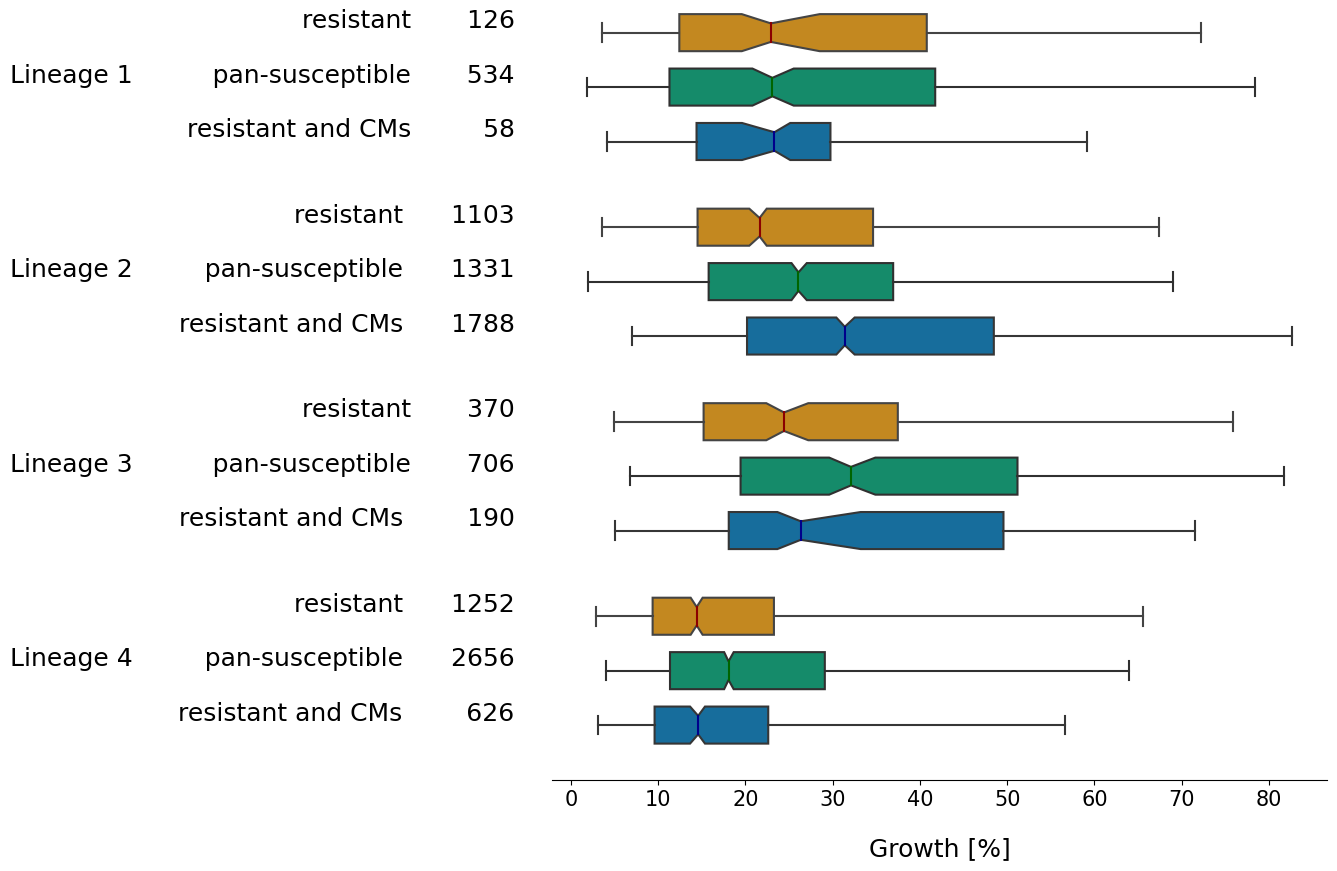

In [25]:
#set color palette
colors = palette("colorblind")

#load UNIQUEIDs of resistant samples with CMs
res_CM_samples = []

for i, name in enumerate(hits_final.resistant_mutation.unique()):
    resistance = MUTATIONS[(MUTATIONS.GENE_MUTATION == name)].UNIQUEID
    hit_samples_local = MUTATIONS[(MUTATIONS.GENE_MUTATION.isin(hits_final.other_mutation.values.tolist())) 
                                  & (MUTATIONS.UNIQUEID.isin(resistance.tolist()))].UNIQUEID.unique()
    res_CM_samples.append(hit_samples_local)

res_CM_samples = numpy.concatenate(res_CM_samples)
res_CM_samples = pandas.Series(res_CM_samples)

#load UNIQUEIDs of resistant samples without CMs
res_samples = EFFECTS[~(EFFECTS.UNIQUEID.isin(res_CM_samples))].UNIQUEID.values.tolist()
res_samples = pandas.Series(res_samples)

fig, (ax_box1, ax_box2, ax_box3, ax_box4, ax_box5, ax_box6, ax_box7, ax_box8, ax_box9, ax_box10, ax_box11, ax_box12, ax_box13, ax_box14, ax_box15, ax_box16) = plt.subplots(16, sharex = True, 
                                                gridspec_kw = {"height_ratios": (0.2, 0.2, 0.2, 0.1, 0.2, 0.2, 0.2, 0.1, 0.2, 0.2, 0.2, 0.1, 0.2, 0.2, 0.2, 0.1)})
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.set_size_inches(10, 10)

axes = [ax_box1, ax_box2, ax_box3, ax_box4, ax_box5, ax_box6, ax_box7, ax_box8, ax_box9, ax_box10, ax_box11, ax_box12, ax_box13, ax_box14, ax_box15, ax_box16]
j=0

lineages = ['Lineage 1', 'Lineage 2', 'Lineage 3', 'Lineage 4']
stats = []

for lineage in lineages:
    
    #load growth data for susceptible UNIQUEIDs
    susceptible = PLATES[(PLATES.UNIQUEID.isin(pan_sus_samples.values.tolist())) & (PLATES.UNIQUEID.isin(GENOMES[GENOMES.MYKROBE_LINEAGE_NAME_1 
                                                       == lineage].index.to_series()))].IM_POS_AVERAGE
    susceptible.dropna(inplace = True)
    
    #load growth data for resistant UNIQUEIDs
    resistant = PLATES[(PLATES.UNIQUEID.isin(res_samples.values.tolist())) & (PLATES.UNIQUEID.isin(GENOMES[GENOMES.MYKROBE_LINEAGE_NAME_1 
                                                       == lineage].index.to_series()))].IM_POS_AVERAGE
    resistant.dropna(inplace = True)
    
    #load growth data for resistant with CMs UNIQUEIDs
    resistant_CM = PLATES[(PLATES.UNIQUEID.isin(res_CM_samples.values.tolist())) & (PLATES.UNIQUEID.isin(GENOMES[GENOMES.MYKROBE_LINEAGE_NAME_1 
                                                       == lineage].index.to_series()))].IM_POS_AVERAGE
    resistant_CM.dropna(inplace = True)
    
    #calculate p-values
    stat1, p1 = mannwhitneyu(resistant, susceptible)
    stat2, p2 = mannwhitneyu(resistant, resistant_CM)
    stat3, p3 = mannwhitneyu(resistant_CM, susceptible)
    
    #save median and CI's
    sus_boot = my_bootstrap(susceptible)
    stats.append(['susceptible', sus_boot[0], sus_boot[1][0], sus_boot[1][1], '', '', 
                  round(numpy.mean(susceptible), 2), len(susceptible)])

    res_boot = my_bootstrap(resistant[:1207])
    stats.append(['resistant and no CMs', res_boot[0], res_boot[1][0], res_boot[1][1], '', str(p1), 
                  round(numpy.mean(resistant), 2), len(resistant)], )

    resCM_boot = my_bootstrap(resistant_CM)
    stats.append(['resistant and CMs', resCM_boot[0], resCM_boot[1][0], resCM_boot[1][1], str(p2), str(p3), 
                  round(numpy.mean(resistant_CM), 2), len(resistant_CM)])
    
    #plot current lineage distributions
    ax = axes[j]
    j = j+1
    
    sns.boxplot(resistant.to_list(), ax = ax, color = colors[1], medianprops={"color": "darkred"}, 
                usermedians = [res_boot[0]], conf_intervals = [res_boot[1]], **box_args)
    if (lineage == 'Lineage 1') or (lineage == 'Lineage 3'):
        ax.set_ylabel ('resistant       ' + str(len(resistant)), fontsize = 18, labelpad = 20, rotation=0, 
                       horizontalalignment='right')  
    else:
        ax.set_ylabel ('resistant      ' + str(len(resistant)), fontsize = 18, labelpad = 20, rotation=0, 
                       horizontalalignment='right') 
#     ax.text(104, 0.1, '[' + str(res_boot[1][0]) + ',' + str(res_boot[1][1]) + ']', 
#             fontdict = dict(fontsize = 15))
    
    ax = axes[j]
    j = j+1
    
    sns.boxplot(susceptible.to_list(), ax = ax, color = colors[2], medianprops={"color": "darkgreen"}, 
                usermedians = [sus_boot[0]], conf_intervals = [sus_boot[1]], **box_args)
    
    if (lineage == 'Lineage 2') or (lineage == 'Lineage 4'):
        ax.set_ylabel (lineage + '         pan-susceptible      ' + str(len(susceptible)), fontsize = 18, labelpad = 20, rotation=0, 
                       horizontalalignment='right')
    else:
        ax.set_ylabel (lineage + '          pan-susceptible       ' + str(len(susceptible)), fontsize = 18, labelpad = 20, rotation=0, 
                       horizontalalignment='right')
        
#     ax.text(104, 0.1, '[' + str(sus_boot[1][0]) + ',' + str(sus_boot[1][1]) + ']', 
#             fontdict = dict(fontsize = 15))
    
    ax = axes[j]
    j = j+2
    
    sns.boxplot(resistant_CM.to_list(), ax = ax, color = colors[0], medianprops={"color": "darkblue"}, 
                usermedians = [resCM_boot[0]], conf_intervals = [resCM_boot[1]], **box_args)
    
    if (lineage == 'Lineage 1'):
        ax.set_ylabel ('resistant and CMs         ' + str(len(resistant_CM)), fontsize = 18, labelpad = 20, rotation=0, 
                       horizontalalignment='right')
    
    elif (lineage == 'Lineage 2'):
        ax.set_ylabel ('resistant and CMs      ' + str(len(resistant_CM)), fontsize = 18, labelpad = 20, rotation=0, 
                       horizontalalignment='right')
        
    else:
        ax.set_ylabel ('resistant and CMs        ' + str(len(resistant_CM)), fontsize = 18, labelpad = 20, rotation=0, 
                       horizontalalignment='right')
        
#     ax.text(104, 0.1, '[' + str(resCM_boot[1][0]) + ',' + str(resCM_boot[1][1]) + ']', 
#             fontdict = dict(fontsize = 15))

#Despine plots
axes = [ax_box1, ax_box2, ax_box3, ax_box4, ax_box5, ax_box6, ax_box7, ax_box8, ax_box9, ax_box10, ax_box11, ax_box12, ax_box13, ax_box14, ax_box15, ax_box16]

for ax in axes:
    sns.despine(ax = ax, top = True, right=True, left = True, bottom = True, offset = False, trim = False)
    ax.tick_params(left=False, bottom=False) 
    ax.set(yticklabels=[])
    ax.set(xlabel='')

#Respine bottom plot
sns.despine(ax = ax_box16, top = True, right=True, left = True, bottom = False, offset = False, trim = False)
ax_box16.tick_params(left = False, bottom = True) 

plt.xlabel("Growth [%]", size = 18, labelpad = 20)
plt.xticks(fontsize = 15)

# Uncomment this for saving image:
#fig.savefig('res_vs_sus_vs_CM_lineages.svg', format='svg', dpi=1200, bbox_inches='tight')

**Supplementary Figure S4:**

Histogram representation of Figure 5C.

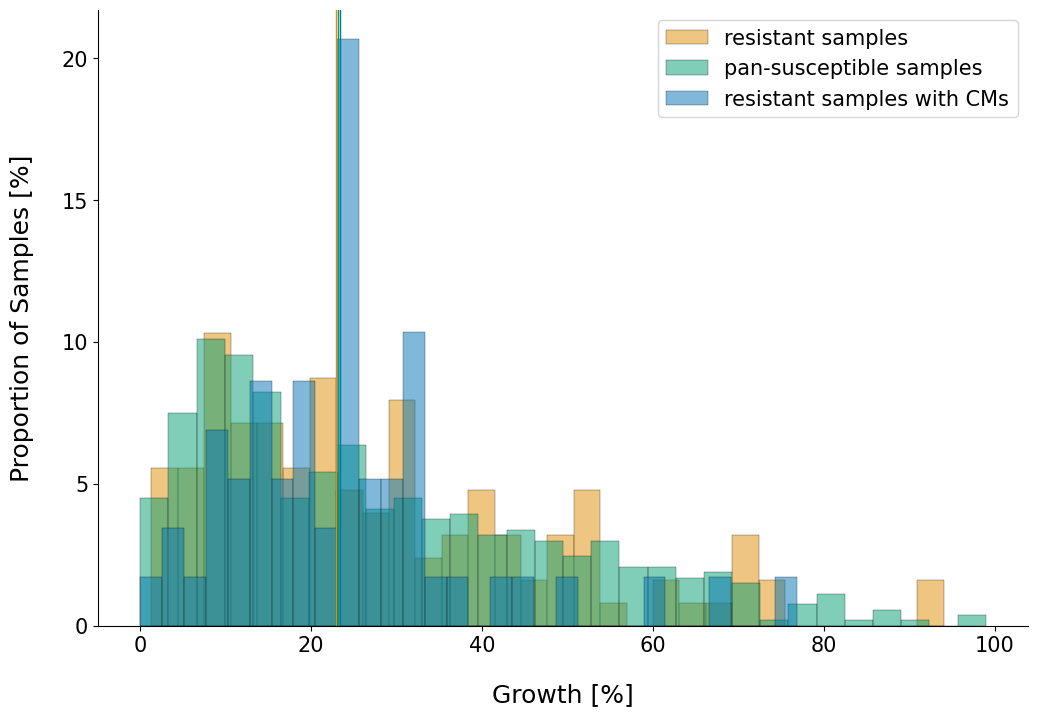

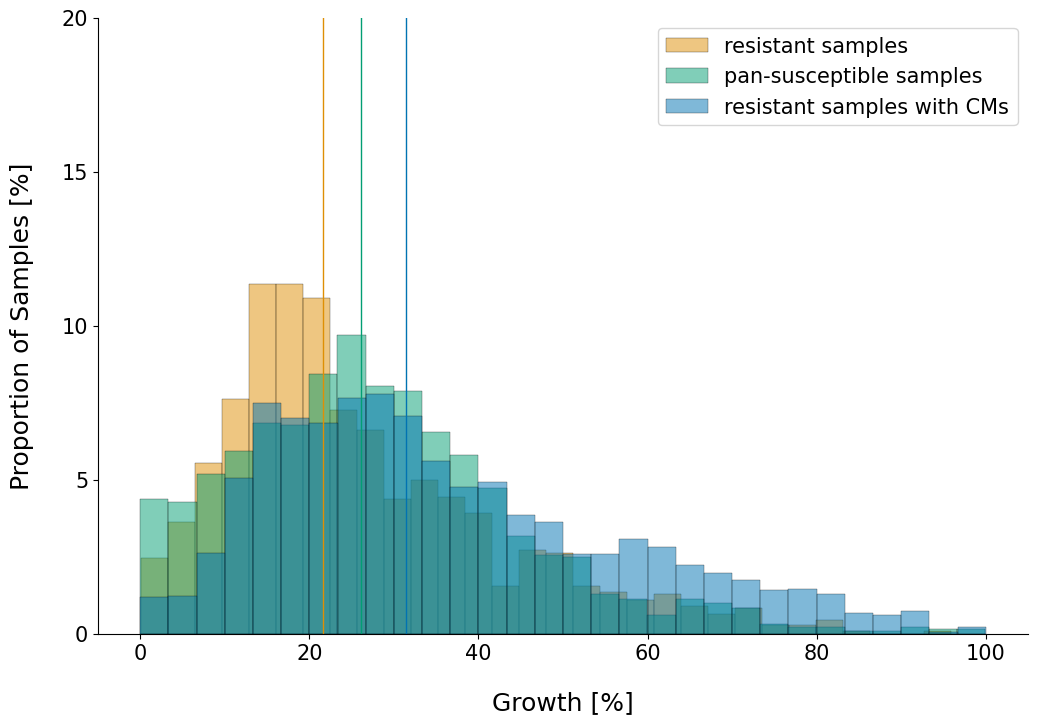

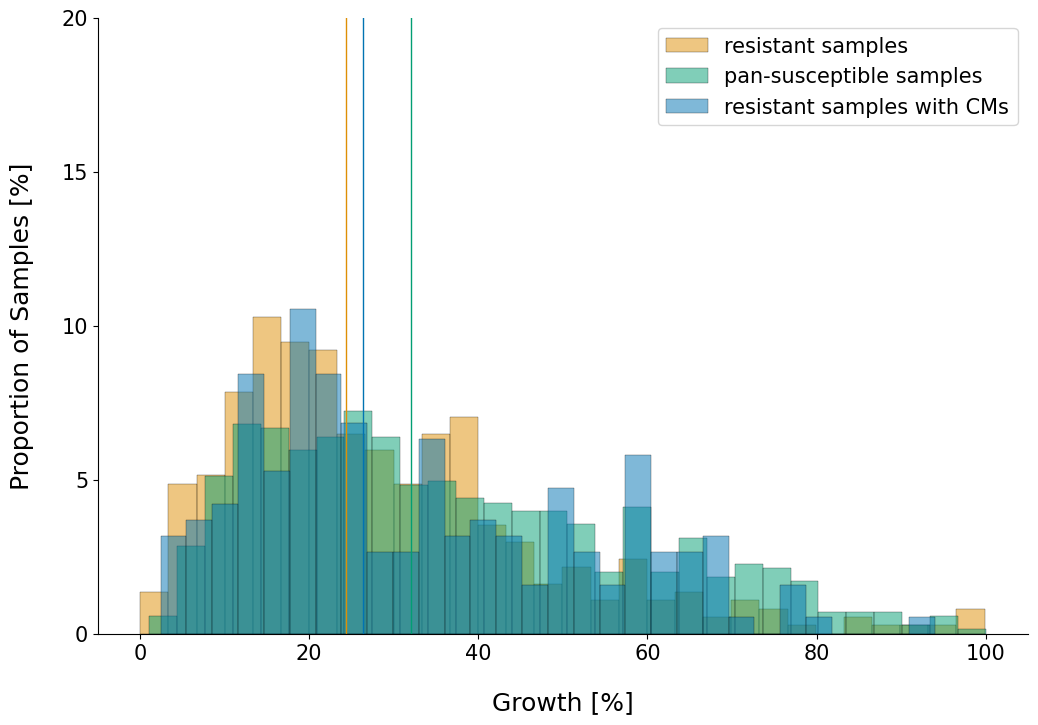

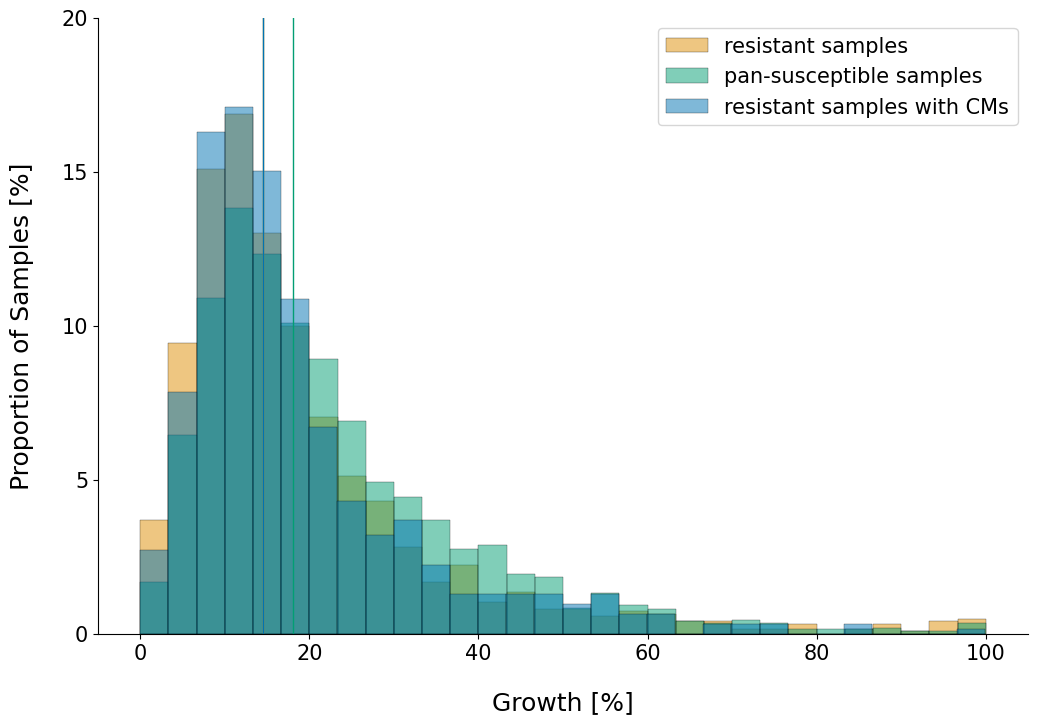

In [26]:
for lineage in lineages:
    
    #load growth data for susceptible UNIQUEIDs
    susceptible = PLATES[(PLATES.UNIQUEID.isin(pan_sus_samples.values.tolist())) & (PLATES.UNIQUEID.isin(GENOMES[GENOMES.MYKROBE_LINEAGE_NAME_1 
                                                       == lineage].index.to_series()))].IM_POS_AVERAGE
    susceptible.dropna(inplace = True)
    
    #load growth data for resistant UNIQUEIDs
    resistant = PLATES[(PLATES.UNIQUEID.isin(res_samples.values.tolist())) & (PLATES.UNIQUEID.isin(GENOMES[GENOMES.MYKROBE_LINEAGE_NAME_1 
                                                       == lineage].index.to_series()))].IM_POS_AVERAGE
    resistant.dropna(inplace = True)
    
    #load growth data for resistant with CMs UNIQUEIDs
    resistant_CM = PLATES[(PLATES.UNIQUEID.isin(res_CM_samples.values.tolist())) & (PLATES.UNIQUEID.isin(GENOMES[GENOMES.MYKROBE_LINEAGE_NAME_1 
                                                       == lineage].index.to_series()))].IM_POS_AVERAGE
    resistant_CM.dropna(inplace = True)        
    
    fig, ax = plt.subplots()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    fig.set_size_inches(12, 8)

    sns.histplot(data = resistant, label="resistant samples", color = colors[1], **hist_args)
    plt.axvline(resistant.median(), color = colors[1], linewidth = 1)

    sns.histplot(data = susceptible, label="pan-susceptible samples", color = colors[2], **hist_args)
    plt.axvline(susceptible.median(), color = colors[2], linewidth = 1)

    sns.histplot(data = resistant_CM, label="resistant samples with CMs", color = colors[0], **hist_args)
    plt.axvline(resistant_CM.median(), color = colors[0], linewidth = 1)

    plt.xlabel("Growth [%]", size = 18, labelpad = 20)
    plt.ylabel("Proportion of Samples [%]", size = 18, labelpad = 20)

    plt.xticks(fontsize = 15)
    plt.yticks(numpy.arange(0, 25, 5.0), fontsize = 15)

    plt.legend(loc = 'upper right', fontsize = 15)
    
    # Uncomment this for creating figure:
    #fig.savefig('res_vs_sus_vs_CM_' + lineage + '.svg', format='svg', dpi=1200)

**Supplementary Table S5:**

Lineage-wise median growth of samples with different compensatory mutations compared to susceptibles and samples with only resistance. The confidence interval (CI) for the median is calculated using bootstrapping where 'CI low' indicates the lower threshold and 'CI high' the upper threshold. P-values are given with respect to resistant (p-value$_{r}$) and susceptible sample growth (p-value$_{s}$) and n indicates the sample size.

In [27]:
table = pandas.DataFrame(stats, columns = ['sample type','median growth [%]', 'CI low', 'CI high', 'p-value to res', 'p-value to sus', 'mean growth [%]', 'n'], index = None)
table = table.drop(['mean growth [%]'], axis = 1)
print(table.to_latex(index = False))

\begin{tabular}{lrrrllr}
\toprule
sample type & median growth [%] & CI low & CI high & p-value to res & p-value to sus & n \\
\midrule
susceptible & 23.090000 & 20.800000 & 25.530000 &  &  & 534 \\
resistant and no CMs & 22.910000 & 19.580000 & 28.510000 &  & 0.7838820857546918 & 126 \\
resistant and CMs & 23.320000 & 19.610000 & 25.130000 & 0.5160312342808111 & 0.5956567395853223 & 58 \\
susceptible & 26.080000 & 25.280000 & 27.030000 &  &  & 1331 \\
resistant and no CMs & 21.620000 & 20.440000 & 22.440000 &  & 2.460868433289354e-05 & 1103 \\
resistant and CMs & 31.390000 & 30.420000 & 32.520000 & 5.646254555889437e-43 & 3.195799610237032e-24 & 1788 \\
susceptible & 32.100000 & 29.600000 & 34.890000 &  &  & 706 \\
resistant and no CMs & 24.420000 & 22.390000 & 27.200000 &  & 8.786026469051608e-09 & 370 \\
resistant and CMs & 26.340000 & 23.660000 & 33.210000 & 0.02077375875480141 & 0.04379136674128141 & 190 \\
susceptible & 18.060000 & 17.560000 & 18.650000 &  &  & 2656 \\
resistant a

**Figure 6: M. tuberculosis clades with clusters of compensatory mutations (CMs) explain some of the high growth densities associated with CMs in Lineage 2**

**Figure 6(A-B):** 

Growth distributions (percentage of covered well area) in Lineage 2 were plotted as a histogram against the proportion of samples that display this amount of growth (bottom) and as a notched box plot reflecting the distribution quantiles (top). Lineage 2 samples were classified as pan-susceptible (green), RIF resistant (red), resistant with the CM I491V/ V483A (blue) and as part of the Lineage 2 subclade where all samples show the CM I491V/ V483A (dark red). For the box plot, half of the data lies within the area of the box and 95% in the area covered by the whiskers. Outliers (5% of the data) were removed to achieve a cleaner representation. Indented area close to the medians indicate their respective confidence interval, while the star (*) indicates a significant Mann-Whitney p-value (p < 0.05%). The respective medians, confidence intervals and the Mann-Whitney p-values are listed in Table 2.

In [28]:
hits_final = pandas.read_csv('fisher_all.csv')
hits_final = hits_final[~(hits_final.other_mutation.apply(lambda x: x[5]==x[-1]))]
hits_final = hits_final.sort_values('both', ascending = False)
#hits_final = hits_final.drop(['p_value', 'None', 'other', 'resistant', 'n_resistant', 'n_other'], axis = 1)
hits_final = hits_final.drop(['None', 'resistant', 'n_resistant', 'n_other'], axis = 1)
hits_final.reset_index(drop = True, inplace = True)

#Explore lineage association of all hit combinations:
#make list of observed combinations of resistance and CM
hit_samples = []
name = []

for i in tqdm(range(0, len(hits_final))):

    line = hits_final.loc[i]

    mut1 = line.resistant_mutation
    mut2 = line.other_mutation
    
    if mut2 == 'rpoC_I491V' or mut2 == 'rpoC_V483A':

        resistance = MUTATIONS[(MUTATIONS.GENE_MUTATION == mut1)].UNIQUEID

        hit_samples_local = MUTATIONS[(MUTATIONS.GENE_MUTATION == mut2) 
                                        & (MUTATIONS.UNIQUEID.isin(resistance.tolist()))]

        name.append(mut1 + '_' + hit_samples_local.GENE_MUTATION)
        hit_samples.append(hit_samples_local.UNIQUEID)

hit_samples = numpy.concatenate(hit_samples)
name = numpy.concatenate(name)
hit_samples = pandas.DataFrame(hit_samples,name,columns = ['UNIQUEID'])
hit_samples

hit_samples = hit_samples.reset_index()
hit_samples.rename(columns = {'index':'mutations'}, inplace = True) 

combinations = hit_samples.mutations.unique()

hit_samples = hit_samples.set_index('mutations')

  0%|          | 0/184126 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

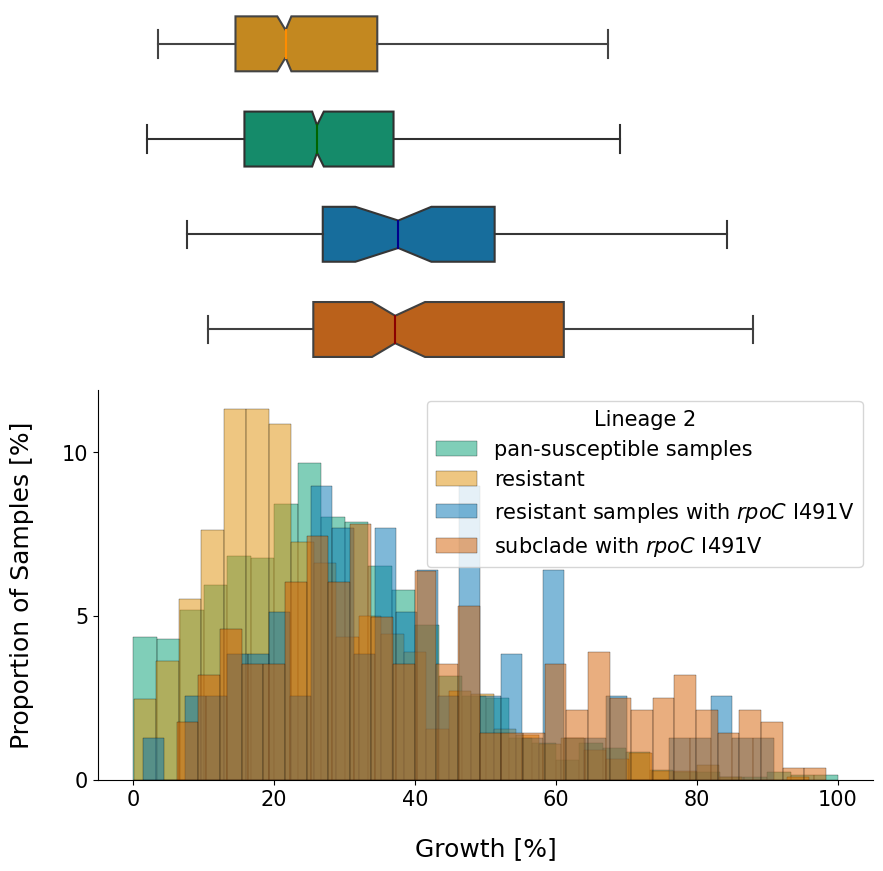

In [29]:
#set color palette
colors = palette("colorblind")

#load growth data for susceptibles in lineage 2
condition1 = GENOMES.WGS_PREDICTION_STRING.str[0:4].isin(['SSSS'])
condition2 = GENOMES.MYKROBE_LINEAGE_NAME_1 == 'Lineage 2'

lineage2 = GENOMES[(condition1) & (condition2)].index.to_series()
susceptible = PLATES[(PLATES.UNIQUEID.isin(lineage2.values.tolist()))].IM_POS_AVERAGE
susceptible.dropna(inplace = True)

#read in UNIQUEIDs of CM subclade
clade = pandas.read_csv('subclade_I491V.csv') #change V483A to I491V to obtain the other plot!
clade = clade.values.tolist()
flat_clade = [item for sublist in clade for item in sublist]

for i, combination in enumerate(tqdm(combinations)): 
    
    res_CM_samples = hit_samples.loc[combination]
     
    if (combination[16:] != 'I491V') | (combination[5:10] != 'S450L'): #change V483A to I491V to obtain the other plot!
        continue

    #load growth data for resistant UNIQUEIDs
    resistant = PLATES[(PLATES.UNIQUEID.isin(res_samples.values.tolist())) 
                       & (PLATES.UNIQUEID.isin(GENOMES[GENOMES.MYKROBE_LINEAGE_NAME_1 
                                                       == 'Lineage 2'].index.to_series()))].IM_POS_AVERAGE
    resistant.dropna(inplace = True)
    
    #load growth data for resistant+CMs samples in lineage 2 + not subclade
    resistant_CM = PLATES[(PLATES.UNIQUEID.isin(res_CM_samples.UNIQUEID.values.tolist())) 
                          & (PLATES.UNIQUEID.isin(GENOMES[GENOMES.MYKROBE_LINEAGE_NAME_1 
                                                          == 'Lineage 2'].index.to_series())) 
                          & (~(PLATES.UNIQUEID.isin(flat_clade)))].IM_POS_AVERAGE
    
    resistant_CM.dropna(inplace = True)
    
    #load growth data for resistant+CMs samples in lineage 2 + subclade
    resistant_CM_clade = PLATES[(PLATES.UNIQUEID.isin(res_CM_samples.UNIQUEID.values.tolist())) 
                      & (PLATES.UNIQUEID.isin(GENOMES[GENOMES.MYKROBE_LINEAGE_NAME_1 
                                                      == 'Lineage 2'].index.to_series()))
                               & (PLATES.UNIQUEID.isin(flat_clade))].IM_POS_AVERAGE
    resistant_CM_clade.dropna(inplace = True)
    
    #calculate p-values
    stat1, p1 = mannwhitneyu(resistant, susceptible)
    stat2, p2 = mannwhitneyu(resistant, resistant_CM)
    stat3, p3 = mannwhitneyu(resistant, resistant_CM_clade)
    stat4, p4 = mannwhitneyu(resistant_CM, susceptible)
    stat5, p5 = mannwhitneyu(resistant_CM, resistant_CM_clade)
    stat6, p6 = mannwhitneyu(resistant_CM_clade, susceptible)
    
    #save median and CIs
    stats = []
    sus_boot = my_bootstrap(susceptible)
    stats.append(['pan-susceptible', sus_boot[0], sus_boot[1][0], sus_boot[1][1], '', '', '', len(susceptible)])
    
    res_boot = my_bootstrap(resistant)
    stats.append(['resistant and no CMs', res_boot[0], res_boot[1][0], res_boot[1][1], '', str(p1), '', len(resistant)])
    
    resCM_boot = my_bootstrap(resistant_CM)
    stats.append(['resistant and CMs', resCM_boot[0], resCM_boot[1][0], resCM_boot[1][1], str(p2), str(p4), '', len(resistant_CM)])
    
    resCMSub_boot = my_bootstrap(resistant_CM_clade)
    stats.append(['resistant and CM subclade', resCMSub_boot[0], resCMSub_boot[1][0], resCMSub_boot[1][1], 
                  str(p3), str(p6), str(p5), len(resistant_CM_clade)])
    

        
        #Plot histograms with boxplots
    fig, (ax_box1, ax_box2, ax_box3, ax_box4, ax_hist) = plt.subplots(5, sharex = True, 
                                                    gridspec_kw = {"height_ratios": (0.15, 0.15, 0.15, 0.15, 0.85)})

    fig.set_size_inches(10, 10)
        
        #Plot histograms

    sns.histplot(data = susceptible, label="pan-susceptible samples", color = colors[2], **hist_args)

    sns.histplot(data = resistant, label="resistant", color = colors[1], **hist_args)

    sns.histplot(data = resistant_CM, label="resistant samples with " + '$\it{rpoC}$' + ' ' + combination[16:], color = colors[0], **hist_args)

    sns.histplot(data = resistant_CM_clade, label="subclade with " + '$\it{rpoC}$' + ' ' + combination[16:], color = colors[3], **hist_args)

    sns.boxplot(resistant.to_list(), ax = ax_box1, color = colors[1], medianprops={"color": "darkorange"}, 
                usermedians = [res_boot[0]], conf_intervals = [res_boot[1]], **box_args) 

    sns.boxplot(susceptible.to_list(), ax = ax_box2, color = colors[2], medianprops={"color": "darkgreen"}, 
                usermedians = [sus_boot[0]], conf_intervals = [sus_boot[1]],**box_args)

    sns.boxplot(resistant_CM.to_list(), ax = ax_box3, color = colors[0], medianprops={"color": "darkblue"}, 
                usermedians = [resCM_boot[0]], conf_intervals = [resCM_boot[1]],**box_args)

    sns.boxplot(resistant_CM_clade.to_list(), ax = ax_box4, color = colors[3], medianprops={"color": "darkred"}, 
                usermedians = [resCMSub_boot[0]], conf_intervals = [resCMSub_boot[1]],**box_args)

    #Despine plots
    sns.despine(top = True, right=True, left = False, bottom = False, offset = False, trim = False)

    axes = [ax_box1, ax_box2, ax_box3, ax_box4]
    for ax in axes:
        sns.despine(ax = ax, top = True, right=True, left = True, bottom = True, offset = False, trim = False)
        ax.tick_params(left=False, bottom=False) 
        ax.set(yticklabels=[])
        ax.set(xlabel='')

    plt.xlabel("Growth [%]", size = 18, labelpad = 20)
    plt.ylabel("Proportion of Samples [%]", size = 18, labelpad = 20)

    plt.xticks(fontsize = 15)
    plt.yticks(numpy.arange(0, 13, 5.0), fontsize = 15)

    plt.legend(loc = 'upper right', fontsize = 15, title = 'Lineage 2', title_fontsize = 15)
        
#Uncomment below save images:
#fig.savefig('investigating_subclades_I491V.svg', format='svg', dpi=1200, bbox_inches='tight')

Investigation of sample sublineages in cluster and outside of cluster

In [30]:
for i, combination in enumerate(tqdm(combinations)): 
    
    res_CM_samples = hit_samples.loc[combination]
    
    if (combination[16:] != 'V483A') | (combination[5:10] != 'S450L'): #change V483A to I491V to obtain the other plot!
        continue
        
    outside_clade = GENOMES[(GENOMES.index.isin(res_CM_samples.UNIQUEID.values.tolist())) 
                          & (GENOMES.index.isin(GENOMES[GENOMES.MYKROBE_LINEAGE_NAME_1 
                                                          == 'Lineage 2'].index.to_series())) 
                          & (~(GENOMES.index.isin(flat_clade)))]
    
    in_clade = GENOMES[(GENOMES.index.isin(res_CM_samples.UNIQUEID.values.tolist())) 
                      & (GENOMES.index.isin(GENOMES[GENOMES.MYKROBE_LINEAGE_NAME_1 
                                                      == 'Lineage 2'].index.to_series()))
                               & (GENOMES.index.isin(flat_clade))]
    
    outside_clade = pandas.DataFrame(outside_clade.MYKROBE_LINEAGE_NAME_2)
    inside_clade = pandas.DataFrame(in_clade.MYKROBE_LINEAGE_NAME_2)
    
outside_clade.MYKROBE_LINEAGE_NAME_2.value_counts()

  0%|          | 0/6 [00:00<?, ?it/s]

MYKROBE_LINEAGE_NAME_2
lineage2.2       240
lineage2.2.10     42
lineage2.2.5      25
lineage2.2.9      25
lineage2.2.7      12
lineage2.2.1       5
lineage2.2.6       4
lineage2.2.3       3
lineage2.2.4       3
lineage2.2.2       1
lineage2.2.8       1
Name: count, dtype: int64

**Table 2:**

Median growth of samples from Lineage 2 with different compensatory mutations, compared to growth of susceptible samples, growth of resistant samples without CMs and growth of a resistant clade that shows a cluster of the respective CM. The confidence interval (CI) for the median is calculated using bootstrapping where 'CI low' indicates the lower threshold and 'CI high' the upper threshold. P-values are given with respect to resistant sample growth (p-value$_{r}$), susceptible sample growth (p-value$_{s}$) and sample growth of resistant samples with CMs outside of the cluster subclade. n indicates the sample size.

In [32]:
table = pandas.DataFrame(stats, columns = ['sample type','median growth [%]', 'CI low', 'CI high', 'p-value to res', 'p-value to sus', 'p-value to res_CM', 'n'], index = None)
print(table.to_latex(index = False))

\begin{tabular}{lrrrlllr}
\toprule
sample type & median growth [%] & CI low & CI high & p-value to res & p-value to sus & p-value to res_CM & n \\
\midrule
pan-susceptible & 26.080000 & 25.390000 & 27.040000 &  &  &  & 1331 \\
resistant and no CMs & 21.620000 & 20.440000 & 22.440000 &  & 2.460868433289354e-05 &  & 1103 \\
resistant and CMs & 37.600000 & 31.520000 & 42.300000 & 9.572098935702982e-11 & 1.1188205568159411e-07 &  & 78 \\
resistant and CM subclade & 37.170000 & 33.890000 & 41.400000 & 2.13709147072763e-33 & 6.521637194830049e-24 & 0.49896024045734455 & 282 \\
\bottomrule
\end{tabular}

